<a href="https://colab.research.google.com/github/DGkurnia/cnkproject/blob/main/BMLP_Derfansyah_Guswiranata_Kurnia_clus_ii.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Perkenalan Diri
## Nama (iddicoding): Derfansyah Guswiranata Kurnia (dgkurnia)
## email dicoding: weerakurnia@gmail

# **1. Perkenalan Dataset**


Tahap pertama, Anda harus mencari dan menggunakan dataset **tanpa label** dengan ketentuan sebagai berikut:

1. **Sumber Dataset**:  
   Dataset dapat diperoleh dari berbagai sumber, seperti public repositories (*Kaggle*, *UCI ML Repository*, *Open Data*) atau data primer yang Anda kumpulkan sendiri.
   
2. **Ketentuan Dataset**:
   - **Tanpa label**: Dataset tidak boleh memiliki label atau kelas.
   - **Jumlah Baris**: Minimal 1000 baris untuk memastikan dataset cukup besar untuk analisis yang bermakna.
   - **Tipe Data**: Harus mengandung data **kategorikal** dan **numerikal**.
     - *Kategorikal*: Misalnya jenis kelamin, kategori produk.
     - *Numerikal*: Misalnya usia, pendapatan, harga.

3. **Pembatasan**:  
   Dataset yang sudah digunakan dalam latihan clustering (seperti customer segmentation) tidak boleh digunakan.

In [1]:
#Pengunduhan dataset ke google colab
from google.colab import files
#ke proses 'upload'

In [2]:
#Tahap penguploadan
uploaded = files.upload()

Saving vgchartz-2024.csv to vgchartz-2024.csv


# **2. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning.

In [3]:
#Peprustakaan dasar
import numpy as np
import pandas as pd
#Grafik
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
#perpustakaan untuk interpolasi
from scipy.interpolate import interp1d
#perpustakaan untuk pairwise
from sklearn.metrics import pairwise_distances

In [4]:
#Bagian K-means
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import silhouette_score
#ke pelabelan

In [5]:
#Perpustakaan untuk inisiasi 'pelabelan' dan 'identifikasi jarak'
from sklearn.preprocessing import LabelEncoder as le
from sklearn.decomposition import PCA
from scipy.spatial import distance
#Inisiasi scaler
from sklearn.preprocessing import StandardScaler #untuk PCA
from sklearn.preprocessing import RobustScaler #hierarki

In [6]:
#instalasi k-medoids (pengembangan K-means)
!pip install scikit-learn-extra
from sklearn_extra.cluster import KMedoids

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 19.5 MB/s eta 0:00:00


In [7]:
#Dasar K-Means untuk K-means dan knee locator
from sklearn.cluster import KMeans
! pip install kneed
from kneed import KneeLocator

In [8]:
# instalasi pool
import warnings #peringatan
import multiprocessing
from multiprocessing import cpu_count, Pool
import os #untuk os
import time #waktu
import datetime #tanggal
#impor Parallel dan delay
from joblib import Parallel, delayed
import gc #pengunduhan file per batch

In [9]:
#Penyimpanan hasil sementara di google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
#Proses Penyampaian ulang
from sklearn.utils import resample

In [11]:
#Bagian ProcessPoolExecutor
from concurrent.futures import ProcessPoolExecutor

In [12]:
#Bagian Jarak Euclidean
from scipy.spatial.distance import euclidean

In [13]:
#Persiapan memori untuk penyimpanan hasil
from joblib import Memory

In [14]:
#instalasi dill
! pip install dill
import dill

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 2.1 MB/s eta 0:00:00


In [15]:
#Silhouette visualizer melalui yellow brick
!pip install yellowbrick
from yellowbrick.cluster import SilhouetteVisualizer

# **3. Memuat Dataset**

Pada tahap ini, Anda perlu memuat dataset ke dalam notebook. Jika dataset dalam format CSV, Anda bisa menggunakan pustaka pandas untuk membacanya. Pastikan untuk mengecek beberapa baris awal dataset untuk memahami strukturnya dan memastikan data telah dimuat dengan benar.

Jika dataset berada di Google Drive, pastikan Anda menghubungkan Google Drive ke Colab terlebih dahulu. Setelah dataset berhasil dimuat, langkah berikutnya adalah memeriksa kesesuaian data dan siap untuk dianalisis lebih lanjut.

In [16]:
#Persiapan dataset melalui Pengunduhan dataset
sdf = pd.read_csv('/content/vgchartz-2024.csv')
sdfc = sdf.copy()

data yang dipakai adalah **'sdfc'** yang merupakan salinan

In [17]:
#Bagian Penyeleksian kolom penjualan
kolpen = ['total_sales', 'na_sales', 'jp_sales', 'pal_sales', 'other_sales'] #indikator bagi penjualan
numerik = sdfc[kolpen].copy() #kolom numerik penjualan
#lihat contoh
cnth = numerik.head(7) #7 sampel
print("contoh data penjualan:")
print(cnth)

contoh data penjualan:
   total_sales  na_sales  jp_sales  pal_sales  other_sales
0        20.32      6.37      0.99       9.85         3.12
1        19.39      6.06      0.60       9.71         3.02
2        16.15      8.41      0.47       5.49         1.78
3        15.86      9.06      0.06       5.33         1.42
4        15.09      6.18      0.41       6.05         2.44
5        14.82      9.07      0.13       4.29         1.33
6        14.74      9.76      0.11       3.73         1.14


# **4. Exploratory Data Analysis (EDA)**

Pada tahap ini, Anda akan melakukan **Exploratory Data Analysis (EDA)** untuk memahami karakteristik dataset. EDA bertujuan untuk:

1. **Memahami Struktur Data**
   - Tinjau jumlah baris dan kolom dalam dataset.  
   - Tinjau jenis data di setiap kolom (numerikal atau kategorikal).

2. **Menangani Data yang Hilang**  
   - Identifikasi dan analisis data yang hilang (*missing values*). Tentukan langkah-langkah yang diperlukan untuk menangani data yang hilang, seperti pengisian atau penghapusan data tersebut.

3. **Analisis Distribusi dan Korelasi**  
   - Analisis distribusi variabel numerik dengan statistik deskriptif dan visualisasi seperti histogram atau boxplot.  
   - Periksa hubungan antara variabel menggunakan matriks korelasi atau scatter plot.

4. **Visualisasi Data**  
   - Buat visualisasi dasar seperti grafik distribusi dan diagram batang untuk variabel kategorikal.  
   - Gunakan heatmap atau pairplot untuk menganalisis korelasi antar variabel.

Tujuan dari EDA adalah untuk memperoleh wawasan awal yang mendalam mengenai data dan menentukan langkah selanjutnya dalam analisis atau pemodelan.

In [18]:
#cek info data
catatan = sdfc.info()
print("informasi data:")
print(catatan)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64016 entries, 0 to 64015
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   img           64016 non-null  object 
 1   title         64016 non-null  object 
 2   console       64016 non-null  object 
 3   genre         64016 non-null  object 
 4   publisher     64016 non-null  object 
 5   developer     63999 non-null  object 
 6   critic_score  6678 non-null   float64
 7   total_sales   18922 non-null  float64
 8   na_sales      12637 non-null  float64
 9   jp_sales      6726 non-null   float64
 10  pal_sales     12824 non-null  float64
 11  other_sales   15128 non-null  float64
 12  release_date  56965 non-null  object 
 13  last_update   17879 non-null  object 
dtypes: float64(6), object(8)
memory usage: 6.8+ MB
informasi data:
None


Hal pengingat
1. Nilai kritik berasal dari nilai skala 1 sampai 10
2. Satuan nilai penjualan adalah juta sehingga nilai 20.05 menyatakan 20 juta lima puluh ribu (2,05 *10^7)

In [19]:
#Pembuatan daftar 'penjualan tahunan' (dfpnjlthn)
dfpnjlthn = sdfc.groupby('release_date')[['total_sales','na_sales',
                                          'jp_sales','pal_sales','other_sales']].sum().sort_values(by=['release_date']).copy() #lihat hasil penjualan
smpdfpnjlthn = dfpnjlthn.head(7) #7 sampel
print("contoh data penjualan tahunan:")
print(smpdfpnjlthn)

contoh data penjualan tahunan:
              total_sales  na_sales  jp_sales  pal_sales  other_sales
release_date                                                         
1971-12-03           0.00      0.00       0.0       0.00         0.00
1973-10-08           0.00      0.00       0.0       0.00         0.00
1975-10-12           0.00      0.00       0.0       0.00         0.00
1977-01-01           2.23      2.08       0.0       0.13         0.02
1977-10-01           0.27      0.26       0.0       0.01         0.00
1978-01-01           2.36      2.20       0.0       0.14         0.00
1978-10-01           0.00      0.00       0.0       0.00         0.00


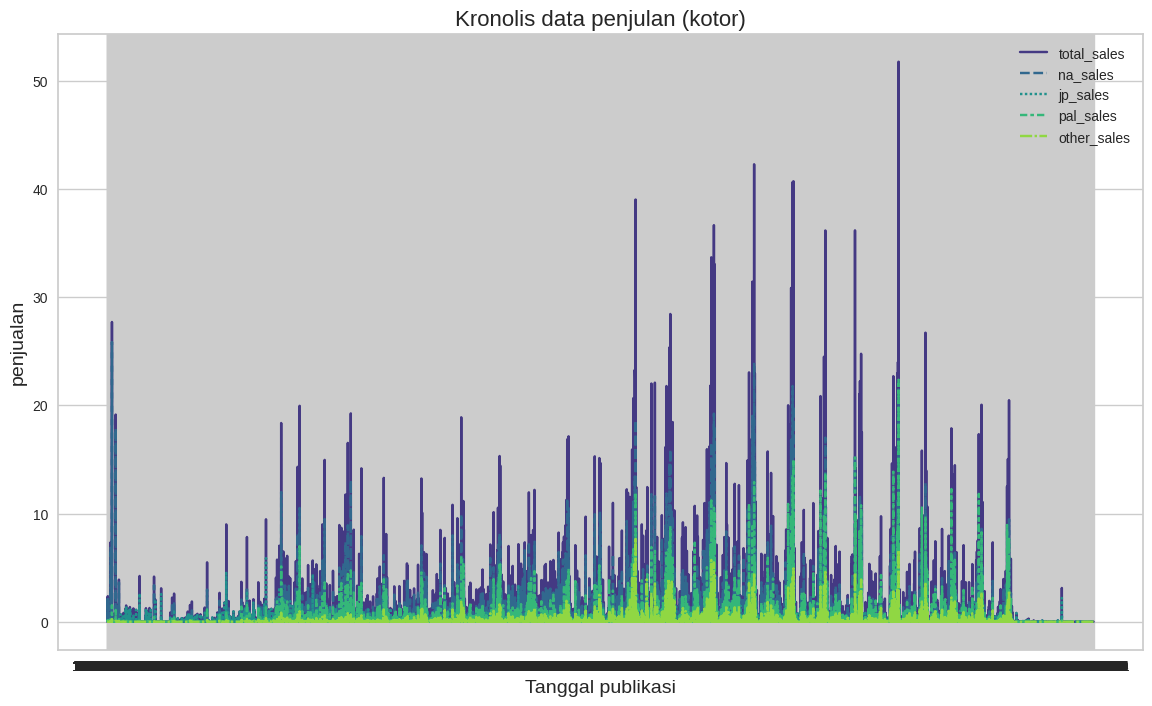

In [20]:
# Grafik Penjualan
plt.figure(figsize=(14, 8))  # Agar terbaca jelas

# Create the line plot with a custom color palette
sns.lineplot(data=dfpnjlthn, palette='viridis')  #

# Judul
plt.title('Kronolis data penjulan (kotor)', fontsize=16)
plt.xlabel('Tanggal publikasi', fontsize=14)  # Nilai tanggal
plt.ylabel('penjualan', fontsize=14)  # Milai penjualan (dalam juta)

# Show the plot
plt.show()

Ini adalah analisis **"data kotor"**

# **5. Data Preprocessing**

Pada tahap ini, data preprocessing adalah langkah penting untuk memastikan kualitas data sebelum digunakan dalam model machine learning. Data mentah sering kali mengandung nilai kosong, duplikasi, atau rentang nilai yang tidak konsisten, yang dapat memengaruhi kinerja model. Oleh karena itu, proses ini bertujuan untuk membersihkan dan mempersiapkan data agar analisis berjalan optimal.

Berikut adalah tahapan-tahapan yang perlu dilakukan, namun **tidak terbatas** pada:
1. Menghapus atau Menangani Data Kosong (Missing Values)
2. Menghapus Data Duplikat
3. Normalisasi atau Standarisasi Fitur
4. Deteksi dan Penanganan Outlier
5. Encoding Data Kategorikal
6. Binning (Pengelompokan Data)

In [21]:
#Tahap 1 (cek data kosong)
totkosong = sdf.isnull().sum() #total data kosong saja
print("total data kosong:")
print(totkosong)

total data kosong:
img                 0
title               0
console             0
genre               0
publisher           0
developer          17
critic_score    57338
total_sales     45094
na_sales        51379
jp_sales        57290
pal_sales       51192
other_sales     48888
release_date     7051
last_update     46137
dtype: int64


In [22]:
#Pengisian kolom pengembang
kolpen = sdfc['developer'].copy() #salinan dari kolom pengembang/'developer'
kolpbt = sdfc['publisher'].copy() #salinan dari penerbit/'publisher'
pengkosong = np.where(kolpen.isnull(),True,False) #cek kolom pengembang kosong
#pengisian pengembang dari penerbit
kolpen = kolpen.fillna(kolpbt)
#cek proses pengisian
smpkpen = sdfc.head(7)
smpkpen

,img,title,console,genre,publisher,developer,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales,release_date,last_update
0,/games/boxart/full_6510540AmericaFrontccc.jpg,Grand Theft Auto V,PS3,Action,Rockstar Games,Rockstar North,9.4,20.32,6.37,0.99,9.85,3.12,2013-09-17,NaN
1,/games/boxart/full_5563178AmericaFrontccc.jpg,Grand Theft Auto V,PS4,Action,Rockstar Games,Rockstar North,9.7,19.39,6.06,0.60,9.71,3.02,2014-11-18,2018-01-03
2,/games/boxart/827563ccc.jpg,Grand Theft Auto: Vice City,PS2,Action,Rockstar Games,Rockstar North,9.6,16.15,8.41,0.47,5.49,1.78,2002-10-28,NaN
3,/games/boxart/full_9218923AmericaFrontccc.jpg,Grand Theft Auto V,X360,Action,Rockstar Games,Rockstar North,NaN,15.86,9.06,0.06,5.33,1.42,2013-09-17,NaN
4,/games/boxart/full_4990510AmericaFrontccc.jpg,Call of Duty: Black Ops 3,PS4,Shooter,Activision,Treyarch,8.1,15.09,6.18,0.41,6.05,2.44,2015-11-06,2018-01-14
5,/games/boxart/full_call-of-duty-modern-warfare...,Call of Duty: Modern Warfare 3,X360,Shooter,Activision,Infinity Ward,8.7,14.82,9.07,0.13,4.29,1.33,2011-11-08,NaN
6,/games/boxart/full_call-of-duty-black-ops_5Ame...,Call of Duty: Black Ops,X360,Shooter,Activision,Treyarch,8.8,14.74,9.76,0.11,3.73,1.14,2010-11-09,NaN


In [23]:
#Pengisian kolom penjualan dengan nilai interpolasi dua tahap
kolpen = numerik.interpolate(method='nearest',limit_direction='both',limit_area='inside')
kolpen = numerik.interpolate(method='linear',limit_direction='both',limit_area='outside')
#cek hasil penyatuan setelah proses pengisian
smpkpen = kolpen.head(7)
#lihat hasil
smpkpen

,total_sales,na_sales,jp_sales,pal_sales,other_sales
0,20.32,6.37,0.99,9.85,3.12
1,19.39,6.06,0.60,9.71,3.02
2,16.15,8.41,0.47,5.49,1.78
3,15.86,9.06,0.06,5.33,1.42
4,15.09,6.18,0.41,6.05,2.44
5,14.82,9.07,0.13,4.29,1.33
6,14.74,9.76,0.11,3.73,1.14


In [24]:
#lihat hasil beda untuk verifikasi
bdjual = sdfc[np.where(abs(sdfc['total_sales'] - sdfc[['na_sales', 'jp_sales', 'pal_sales', 'other_sales']].sum(axis=1)) > 0.1,True, False)].shape[0]
print("jumlah perbedaan :")
print(bdjual)

jumlah perbedaan :
0


## Pengisian tanggal yang kosong

In [25]:
#Bagian 1 (pembaruan jika tidak memiliki tanggal publikasi)
koltang = sdfc['release_date'].isnull() & sdfc['last_update'].notnull() #Kondisi 1
sdfc.loc[np.where(koltang, True, False), 'release_date'] = sdfc.loc[np.where(koltang, True, False),'release_date'].fillna(sdfc['last_update'])
#cek pengisian pertama
inspk1 = sdfc[np.where(koltang, True, False)].head(7)
inspk1
#ke tahap 2

,img,title,console,genre,publisher,developer,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales,release_date,last_update
6347,/games/boxart/full_dangan-ronpa_0JapanFront.jpg,Danganronpa: Trigger Happy Havoc,PSP,Adventure,Unknown,Spike,NaN,0.24,NaN,0.24,NaN,NaN,2018-01-11,2018-01-11
14436,/games/boxart/full_8639439JapanFrontccc.jpg,PriPara All Idol Perfect Stage!,NS,Misc,Unknown,Takara Tomy ARTS,NaN,0.03,NaN,0.03,NaN,NaN,2018-04-04,2018-04-04
15449,/games/boxart/full_9121088AmericaFrontccc.jpg,Zumba Fitness: World Party,X360,Misc,Unknown,Zoe Mode,NaN,0.02,NaN,NaN,0.02,0.0,2018-04-01,2018-04-01
19006,/games/boxart/full_8394432AmericaFrontccc.jpg,How to Survive 2,PC,Action,Unknown,EKO Software,NaN,NaN,NaN,NaN,NaN,NaN,2019-02-02,2019-02-02
19066,/games/boxart/full_6903656AmericaFrontccc.jpg,Geometry Dash,PC,Action,Unknown,RobTop Games,NaN,NaN,NaN,NaN,NaN,NaN,2019-02-03,2019-02-03
19069,/games/boxart/full_6115800AmericaFrontccc.jpg,Who's Your Daddy,PC,Action,Unknown,Evil Tortilla Games,NaN,NaN,NaN,NaN,NaN,NaN,2019-02-03,2019-02-03
19093,/games/boxart/full_4549936AmericaFrontccc.jpg,Super Hexagon,PC,Action,Unknown,Terry Cavanagh,NaN,NaN,NaN,NaN,NaN,NaN,2019-02-05,2019-02-05


In [26]:
#Kondisi 2 (tidak memiliki tanggal pembaruan)
koltang = sdfc['release_date'].notnull() & sdfc['last_update'].isnull()
sdfc.loc[np.where(koltang, True, False), 'last_update'] = sdfc.loc[np.where(koltang, True, False),'last_update'].fillna(sdfc['release_date'])
#cek bagian kedia
sdfc[np.where(koltang, True, False)].head(7)

,img,title,console,genre,publisher,developer,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales,release_date,last_update
0,/games/boxart/full_6510540AmericaFrontccc.jpg,Grand Theft Auto V,PS3,Action,Rockstar Games,Rockstar North,9.4,20.32,6.37,0.99,9.85,3.12,2013-09-17,2013-09-17
2,/games/boxart/827563ccc.jpg,Grand Theft Auto: Vice City,PS2,Action,Rockstar Games,Rockstar North,9.6,16.15,8.41,0.47,5.49,1.78,2002-10-28,2002-10-28
3,/games/boxart/full_9218923AmericaFrontccc.jpg,Grand Theft Auto V,X360,Action,Rockstar Games,Rockstar North,NaN,15.86,9.06,0.06,5.33,1.42,2013-09-17,2013-09-17
5,/games/boxart/full_call-of-duty-modern-warfare...,Call of Duty: Modern Warfare 3,X360,Shooter,Activision,Infinity Ward,8.7,14.82,9.07,0.13,4.29,1.33,2011-11-08,2011-11-08
6,/games/boxart/full_call-of-duty-black-ops_5Ame...,Call of Duty: Black Ops,X360,Shooter,Activision,Treyarch,8.8,14.74,9.76,0.11,3.73,1.14,2010-11-09,2010-11-09
10,/games/boxart/full_809251AmericaFrontccc.jpg,Call of Duty: Modern Warfare 2,X360,Shooter,Activision,Infinity Ward,9.5,13.53,8.54,0.08,3.63,1.28,2009-11-10,2009-11-10
12,/games/boxart/full_call-of-duty-modern-warfare...,Call of Duty: Modern Warfare 3,PS3,Shooter,Activision,Infinity Ward,8.8,13.35,5.54,0.49,5.78,1.54,2011-11-08,2011-11-08


In [27]:
#Kondisi 3 (keduanya kosong)
koltang = sdfc['release_date'].isnull() & sdfc['last_update'].isnull()
rctgl = sdfc[koltang].describe().round(3) #lihat hasil
rctgl #cek kolom koson

,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales
count,25.000,87.000,17.000,36.000,47.000,56.000
mean,6.868,0.072,0.045,0.074,0.046,0.011
std,1.633,0.210,0.080,0.090,0.163,0.045
min,2.500,0.000,0.000,0.000,0.000,0.000
25%,6.000,0.000,0.000,0.018,0.000,0.000
50%,7.000,0.020,0.010,0.040,0.010,0.000
75%,8.000,0.060,0.020,0.103,0.025,0.000
max,9.000,1.840,0.250,0.420,1.100,0.330


Deskripsi menyatakan data bersih

In [28]:
#Pengisian tanggal
sdfc['release_date'] = sdfc['release_date'].fillna(datetime.datetime(1900, 1, 1)).copy()
sdfc['last_update'] = sdfc['last_update'].fillna(datetime.datetime(1900, 1, 1)).copy()

In [29]:
#isi nilai kritik
nilkrit = sdfc['critic_score'].copy()
nilkrit = nilkrit.interpolate(method='nearest',limit_direction='both',limit_area='inside') #tahap 1
nilkrit = nilkrit.interpolate(method='linear',limit_direction='both',limit_area='outside')
#lihat kolom
sdfc['critic_score'] = nilkrit
nilkrit.describe()

,critic_score
count,64016.000000
mean,7.046607
std,1.550054
min,1.000000
25%,6.200000
50%,7.300000
75%,8.100000
max,10.000000


In [30]:
#lihat contoh kolom jadi
koltgl = pd.concat([sdfc['release_date'],sdfc['last_update']], axis=1, sort=True, copy=True) #Keamanan
#lihat info
inftgl = koltgl.info()
inftgl

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64016 entries, 0 to 64015
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   release_date  64016 non-null  object
 1   last_update   64016 non-null  object
dtypes: object(2)
memory usage: 1000.4+ KB


#### Persiapan kolom untuk penyatuan

In [31]:
#Tahap 1 (penyatuan penjualan dan kritik)
totnumkol = pd.concat([kolpen, nilkrit], axis=1, sort=True, copy=True) #Jangan pakai data asli
infototkolnum = totnumkol.info()
print("informasi data:")
infototkolnum

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64016 entries, 0 to 64015
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   total_sales   64016 non-null  float64
 1   na_sales      57731 non-null  float64
 2   jp_sales      51826 non-null  float64
 3   pal_sales     57919 non-null  float64
 4   other_sales   60222 non-null  float64
 5   critic_score  64016 non-null  float64
dtypes: float64(6)
memory usage: 2.9 MB
informasi data:


Bagian 1 dari kolom jadi (walau ada nilai kosong)

In [32]:
#Tahap 2: Inspeksi untuk seleksi kolom (penyatuan hasil data)
sisa = sdfc.iloc[:,:5].copy()
sisa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64016 entries, 0 to 64015
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   img        64016 non-null  object
 1   title      64016 non-null  object
 2   console    64016 non-null  object
 3   genre      64016 non-null  object
 4   publisher  64016 non-null  object
dtypes: object(5)
memory usage: 2.4+ MB


Bagian 2

In [33]:
#Persiapan kolom bersih untuk pembuatan cluster
sdfcbsh = pd.concat([sisa,totnumkol, koltgl], axis=1, sort=True, copy=True) #Ak harap benar
infodfbsh = sdfcbsh.info()
#lihat info
infodfbsh

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64016 entries, 0 to 64015
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   img           64016 non-null  object 
 1   title         64016 non-null  object 
 2   console       64016 non-null  object 
 3   genre         64016 non-null  object 
 4   publisher     64016 non-null  object 
 5   total_sales   64016 non-null  float64
 6   na_sales      57731 non-null  float64
 7   jp_sales      51826 non-null  float64
 8   pal_sales     57919 non-null  float64
 9   other_sales   60222 non-null  float64
 10  critic_score  64016 non-null  float64
 11  release_date  64016 non-null  object 
 12  last_update   64016 non-null  object 
dtypes: float64(6), object(7)
memory usage: 6.3+ MB


Masih ada sisa kolom kotor di data penjualan

In [34]:
#Pembersihan tahp 2 untuk penjualan
klpen2 = sdfcbsh.iloc[:,6:10].copy() #pembersihan ulang
klpen2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64016 entries, 0 to 64015
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   na_sales     57731 non-null  float64
 1   jp_sales     51826 non-null  float64
 2   pal_sales    57919 non-null  float64
 3   other_sales  60222 non-null  float64
dtypes: float64(4)
memory usage: 2.0 MB


Kolom bersih untuk dataset bersih (dari kolom 7 ke kolom 10)

In [35]:
#Pengisian kolom kosong di tabel gabungan melalui interpolasi
klpen2 = klpen2.interpolate(method='nearest',limit_direction='both',limit_area='inside') #tahap 1
klpen2 = klpen2.interpolate(method='linear',limit_direction='both',limit_area='outside') #tahap 2
klpen2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64016 entries, 0 to 64015
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   na_sales     64016 non-null  float64
 1   jp_sales     64016 non-null  float64
 2   pal_sales    64016 non-null  float64
 3   other_sales  64016 non-null  float64
dtypes: float64(4)
memory usage: 2.0 MB


In [36]:
#cek kolom setelah pembersihan
dfbshp1 = sdfcbsh.iloc[:, :6].copy() #samapai penjualan
dfbshp2 = sdfcbsh.iloc[:, 10:].copy() #dari nilai kritik
dfbshmk2 = pd.concat([dfbshp1, klpen2, dfbshp2], axis=1, sort=True, copy=True) #Jangan salah lagi
dfbshmk2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64016 entries, 0 to 64015
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   img           64016 non-null  object 
 1   title         64016 non-null  object 
 2   console       64016 non-null  object 
 3   genre         64016 non-null  object 
 4   publisher     64016 non-null  object 
 5   total_sales   64016 non-null  float64
 6   na_sales      64016 non-null  float64
 7   jp_sales      64016 non-null  float64
 8   pal_sales     64016 non-null  float64
 9   other_sales   64016 non-null  float64
 10  critic_score  64016 non-null  float64
 11  release_date  64016 non-null  object 
 12  last_update   64016 non-null  object 
dtypes: float64(6), object(7)
memory usage: 6.3+ MB


df untuk pelabelan memiliki indikator berikut
1. kolom 'kemungkinan generasi' menandakan jenis generasi
2. kolom 'kemungkinan menyenangkan' merupakan penanda **"bisa dimainkan ulang"** atau *"replyability"*

# **6. Pembangunan Model Clustering**

## **a. Pembangunan Model Clustering**

Pada tahap ini, Anda membangun model clustering dengan memilih algoritma yang sesuai untuk mengelompokkan data berdasarkan kesamaan. Berikut adalah **rekomendasi** tahapannya.
1. Pilih algoritma clustering yang sesuai.
2. Latih model dengan data menggunakan algoritma tersebut.

#### Proses Pelabelan

In [37]:
#Persiapan untuk pengisian melalui deklarasi jenis konsol
jkonsol = sdfcbsh['console'].unique().copy() #salinan saja
print("jenis konsol:")
print(jkonsol)

jenis konsol:
['PS3' 'PS4' 'PS2' 'X360' 'XOne' 'PC' 'PSP' 'Wii' 'PS' 'DS' '2600' 'GBA'
 'NES' 'XB' 'PSN' 'GEN' 'PSV' 'DC' 'N64' 'SAT' 'SNES' 'GBC' 'GC' 'NS'
 '3DS' 'GB' 'WiiU' 'WS' 'VC' 'NG' 'WW' 'SCD' 'PCE' 'XBL' '3DO' 'GG' 'OSX'
 'Mob' 'PCFX' 'Series' 'All' 'iOS' '5200' 'And' 'DSiW' 'Lynx' 'Linux' 'MS'
 'ZXS' 'ACPC' 'Amig' '7800' 'DSi' 'AJ' 'WinP' 'iQue' 'GIZ' 'VB' 'Ouya'
 'NGage' 'AST' 'MSD' 'S32X' 'XS' 'PS5' 'Int' 'CV' 'Arc' 'C64' 'FDS' 'MSX'
 'OR' 'C128' 'CDi' 'CD32' 'BRW' 'FMT' 'ApII' 'Aco' 'BBCM' 'TG16']


In [38]:
#Bagian jenis game (deklarasi jenis game)
jaksi = sdfcbsh['genre'].unique().copy() #salinan saja
print("jenis aksi:")
print(jaksi)

jenis aksi:
['Action' 'Shooter' 'Action-Adventure' 'Sports' 'Role-Playing'
 'Simulation' 'Racing' 'Music' 'Misc' 'Fighting' 'Platform' 'Adventure'
 'Strategy' 'Puzzle' 'MMO' 'Sandbox' 'Party' 'Education' 'Board Game'
 'Visual Novel']


In [39]:
#Inisiasi pelabelan melalui label encoder
le_k = le()  # Untuk konsol
le_j = le()  # Untuk jenis game

Hal penginat untuk selsksi fitur adalah **"dua"** aspek
* le_k untuk konsol
* le_j untuk jenis permainan

In [40]:
#Pelabelan
kolkon = sdfcbsh['console'].copy() #aplikasi untuk konsol
koljen = sdfcbsh['genre'].copy() #aplikasi untuk genre
#eksekusi pelabelan
matkon = le_k.fit_transform(kolkon)  # Konsol
matjen = le_j.fit_transform(koljen)    # Jenis game

In [41]:
#persiapan df
dfkon = pd.DataFrame(data=matkon, columns=['kemungkinan generasi'], copy=True)  # DF untuk konsol
dfjen = pd.DataFrame(data=matjen, columns=['kemungkinan jenis permainan'], copy=True)  # DF untuk jenis
#ke hasil untuk pemeriksaan

In [42]:
#lihat hasil
infsamp1 = dfkon.info()
infsamp2 = dfjen.info()
print(infsamp1)
print(infsamp2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64016 entries, 0 to 64015
Data columns (total 1 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   kemungkinan generasi  64016 non-null  int64
dtypes: int64(1)
memory usage: 500.2 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64016 entries, 0 to 64015
Data columns (total 1 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   kemungkinan jenis permainan  64016 non-null  int64
dtypes: int64(1)
memory usage: 500.2 KB
None
None


In [43]:
#penyatuan kolom pelabelan
hslvek = pd.concat([dfkon, dfjen], axis=1, sort=True, copy=True)
hslvek.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64016 entries, 0 to 64015
Data columns (total 2 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   kemungkinan generasi         64016 non-null  int64
 1   kemungkinan jenis permainan  64016 non-null  int64
dtypes: int64(2)
memory usage: 1000.4 KB


In [44]:
#Penyatuan dataset untuk penskalaan
sdfkomb = pd.concat([dfbshmk2, hslvek], axis=1, sort=True, copy=True) #untuk kluster
sdfkomb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64016 entries, 0 to 64015
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   img                          64016 non-null  object 
 1   title                        64016 non-null  object 
 2   console                      64016 non-null  object 
 3   genre                        64016 non-null  object 
 4   publisher                    64016 non-null  object 
 5   total_sales                  64016 non-null  float64
 6   na_sales                     64016 non-null  float64
 7   jp_sales                     64016 non-null  float64
 8   pal_sales                    64016 non-null  float64
 9   other_sales                  64016 non-null  float64
 10  critic_score                 64016 non-null  float64
 11  release_date                 64016 non-null  object 
 12  last_update                  64016 non-null  object 
 13  kemungkinan gene

Tabel **'sdfkomb'** ada 14 kolom dan 64016 baris dengan 2 kolom pelabelan
- Kolom 'kemungkinan generasi'
- Kolom 'kemungkinan jenis permainan'

In [45]:
#ambil kolom penting (label dan numerik)
lbl = sdfkomb.iloc[:, [13,14]].copy() #bagian label
numkolii = sdfkomb.iloc[:, 5:11].copy() #kolom numerik untuk penskalaan
#persiapan kolom analisis numerik
stdscal = StandardScaler() # inspeksi PCA
rbsscal = RobustScaler() #pergantian ke K-medoids

Label untuk penskalaan dengan dua metode berbeda

In [46]:
#Eksekusi penskalaan (dua kali)
stdnmk = stdscal.fit_transform(numkolii) #untuk PCA
rbnmk = rbsscal.fit_transform(stdnmk) #untuk K-medoid

In [47]:
#Pengubahan ke df pelabelan
dfstdnmk = pd.DataFrame(data=stdnmk, columns=numkolii.columns, copy=True)
dfrbnmk = pd.DataFrame(data=rbnmk, columns=numkolii.columns, copy=True)

In [48]:
#Lihat hasil (standar)
dfstdnmk.head(7)

,total_sales,na_sales,jp_sales,pal_sales,other_sales,critic_score
0,43.291200,25.764981,9.890744,52.679756,48.324018,1.518277
1,41.299748,24.499722,5.872512,51.928485,46.769901,1.711821
2,34.361784,34.091206,4.533102,29.283037,27.498858,1.647306
3,33.740793,36.744169,0.308807,28.424442,21.904039,1.647306
4,32.091956,24.989500,3.914912,32.288121,37.756026,0.679590
5,31.513792,36.784984,1.030028,22.843574,20.505334,1.066677
6,31.342484,39.601207,0.823965,19.838490,17.552513,1.131191


In [49]:
#lihat hasil (robust)
dfrbnmk.head(7)

,total_sales,na_sales,jp_sales,pal_sales,other_sales,critic_score
0,1016.0,637.0,99.0,52.857266,48.488431,1.105263
1,969.5,606.0,60.0,52.105995,46.934315,1.263158
2,807.5,841.0,47.0,29.460547,27.663272,1.210526
3,793.0,906.0,6.0,28.601952,22.068453,1.210526
4,754.5,618.0,41.0,32.465630,37.920440,0.421053
5,741.0,907.0,13.0,23.021083,20.669748,0.736842
6,737.0,976.0,11.0,20.016000,17.716927,0.789474


Semua aspek penjualan dinyatakan dalam juta [1000 juta adalah 1 miliar]

## **b. Evaluasi Model Clustering**

Untuk menentukan jumlah cluster yang optimal dalam model clustering, Anda dapat menggunakan metode Elbow atau Silhouette Score.

Metode ini membantu kita menemukan jumlah cluster yang memberikan pemisahan terbaik antar kelompok data, sehingga model yang dibangun dapat lebih efektif. Berikut adalah **rekomendasi** tahapannya.
1. Gunakan Silhouette Score dan Elbow Method untuk menentukan jumlah cluster optimal.
2. Hitung Silhouette Score sebagai ukuran kualitas cluster.

In [50]:
#Bagian awal (siapkan bahanya)
sdfbhn = pd.concat([dfrbnmk, lbl], axis=1, sort=True, copy=True) #pakai hasil robust
sdfbhn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64016 entries, 0 to 64015
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   total_sales                  64016 non-null  float64
 1   na_sales                     64016 non-null  float64
 2   jp_sales                     64016 non-null  float64
 3   pal_sales                    64016 non-null  float64
 4   other_sales                  64016 non-null  float64
 5   critic_score                 64016 non-null  float64
 6   kemungkinan generasi         64016 non-null  int64  
 7   kemungkinan jenis permainan  64016 non-null  int64  
dtypes: float64(6), int64(2)
memory usage: 3.9 MB


dataframe untuk evaluasi adalah **"sdfbhn"** dengan dua label

In [51]:
#pengambilan nilai untuk analisis fitur
nilkomp = sdfbhn.values.copy() #Nilai untuk inspeksi K-medoid

In [52]:
#Deklarasi Bagian fungsi inspeksi kluster (Deklarasi batas)
optsil = 0.70 #Nilai optimal untuk Silhouette
minsil = 0.55 # Nilai minimal
pjgdata = len(nilkomp) #Panjang data utama
klrange = range(2,11) #Batas kisaran kluster
rstateval = 600 #Aspek 'Random State'
size = 1000 #Batas sampel
#ke fungsi

In [53]:
#Fungsi eksekusi inspeksi kluster (normal)
def inspeksi_klus(nilkomp, cluster_range=klrange, random_states=[rstateval], sample_size=size,
                 optsil=optsil, minsil=minsil):

    fig, ax = plt.subplots(figsize=(32, 32), nrows=5, ncols=2)

    # Persiapan sampel jika besar
    nilai_sampel = pd.DataFrame(nilkomp)

    if sample_size < pjgdata:
        sampel = nilai_sampel.sample(n=sample_size, random_state=40)
    else:
        sampel = nilai_sampel

    # Iterasi sampel di setiap kluster dengan mengabaikan peringatan tentang klaster kosong
    for random_state in random_states:

        print(f"Dengan fasa acak: {random_state}")  # Percetakan fasa acak

        # Iterasi kluster untuk pemeriksaan dan pengabaian peringatan tentang klaster kosong
        for nklus in cluster_range:

            try:
                kmedoid_model = KMedoids(n_clusters=nklus, random_state=random_state)

                # Penyesuaian dengan kondisi sesuai
                kmedoid_model.fit(sampel.values)

                q, mod = divmod(nklus, 2)

                sil = SilhouetteVisualizer(kmedoid_model, is_fitted=True, ax=ax[q-1][mod])

                # Peringatan kluster
                with warnings.catch_warnings():
                    warnings.filterwarnings('ignore', category=UserWarning)

                    sil.fit(sampel.values)

                sil.finalize()

                # Nilai siluet

                silhouette_score = sil.silhouette_score_

                print(f"Kluster: {nklus}, Nilai siluet: {silhouette_score:.3g}")

            except Exception as e:
                print(f"Error occurred for Kluster {nklus}: {e}")
#Ke Bagian Eksekusi

Dengan fasa acak: 600
Kluster: 2, Nilai siluet: 0.277


/usr/local/lib/python3.10/dist-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  warnings.warn(


Kluster: 3, Nilai siluet: 0.347
Kluster: 4, Nilai siluet: 0.0726


/usr/local/lib/python3.10/dist-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  warnings.warn(


Kluster: 5, Nilai siluet: 0.249
Kluster: 6, Nilai siluet: 0.262


/usr/local/lib/python3.10/dist-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 7 is empty! self.labels_[self.medoid_indices_[7]] may not be labeled with its corresponding cluster (7).
  warnings.warn(


Kluster: 7, Nilai siluet: 0.24
Kluster: 8, Nilai siluet: 0.11


/usr/local/lib/python3.10/dist-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 7 is empty! self.labels_[self.medoid_indices_[7]] may not be labeled with its corresponding cluster (7).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 8 is empty! self.labels_[self.medoid_indices_[8]] may not be labeled with its corresponding cluster (8).
  warnings.warn(


Kluster: 9, Nilai siluet: 0.301
Kluster: 10, Nilai siluet: 0.281


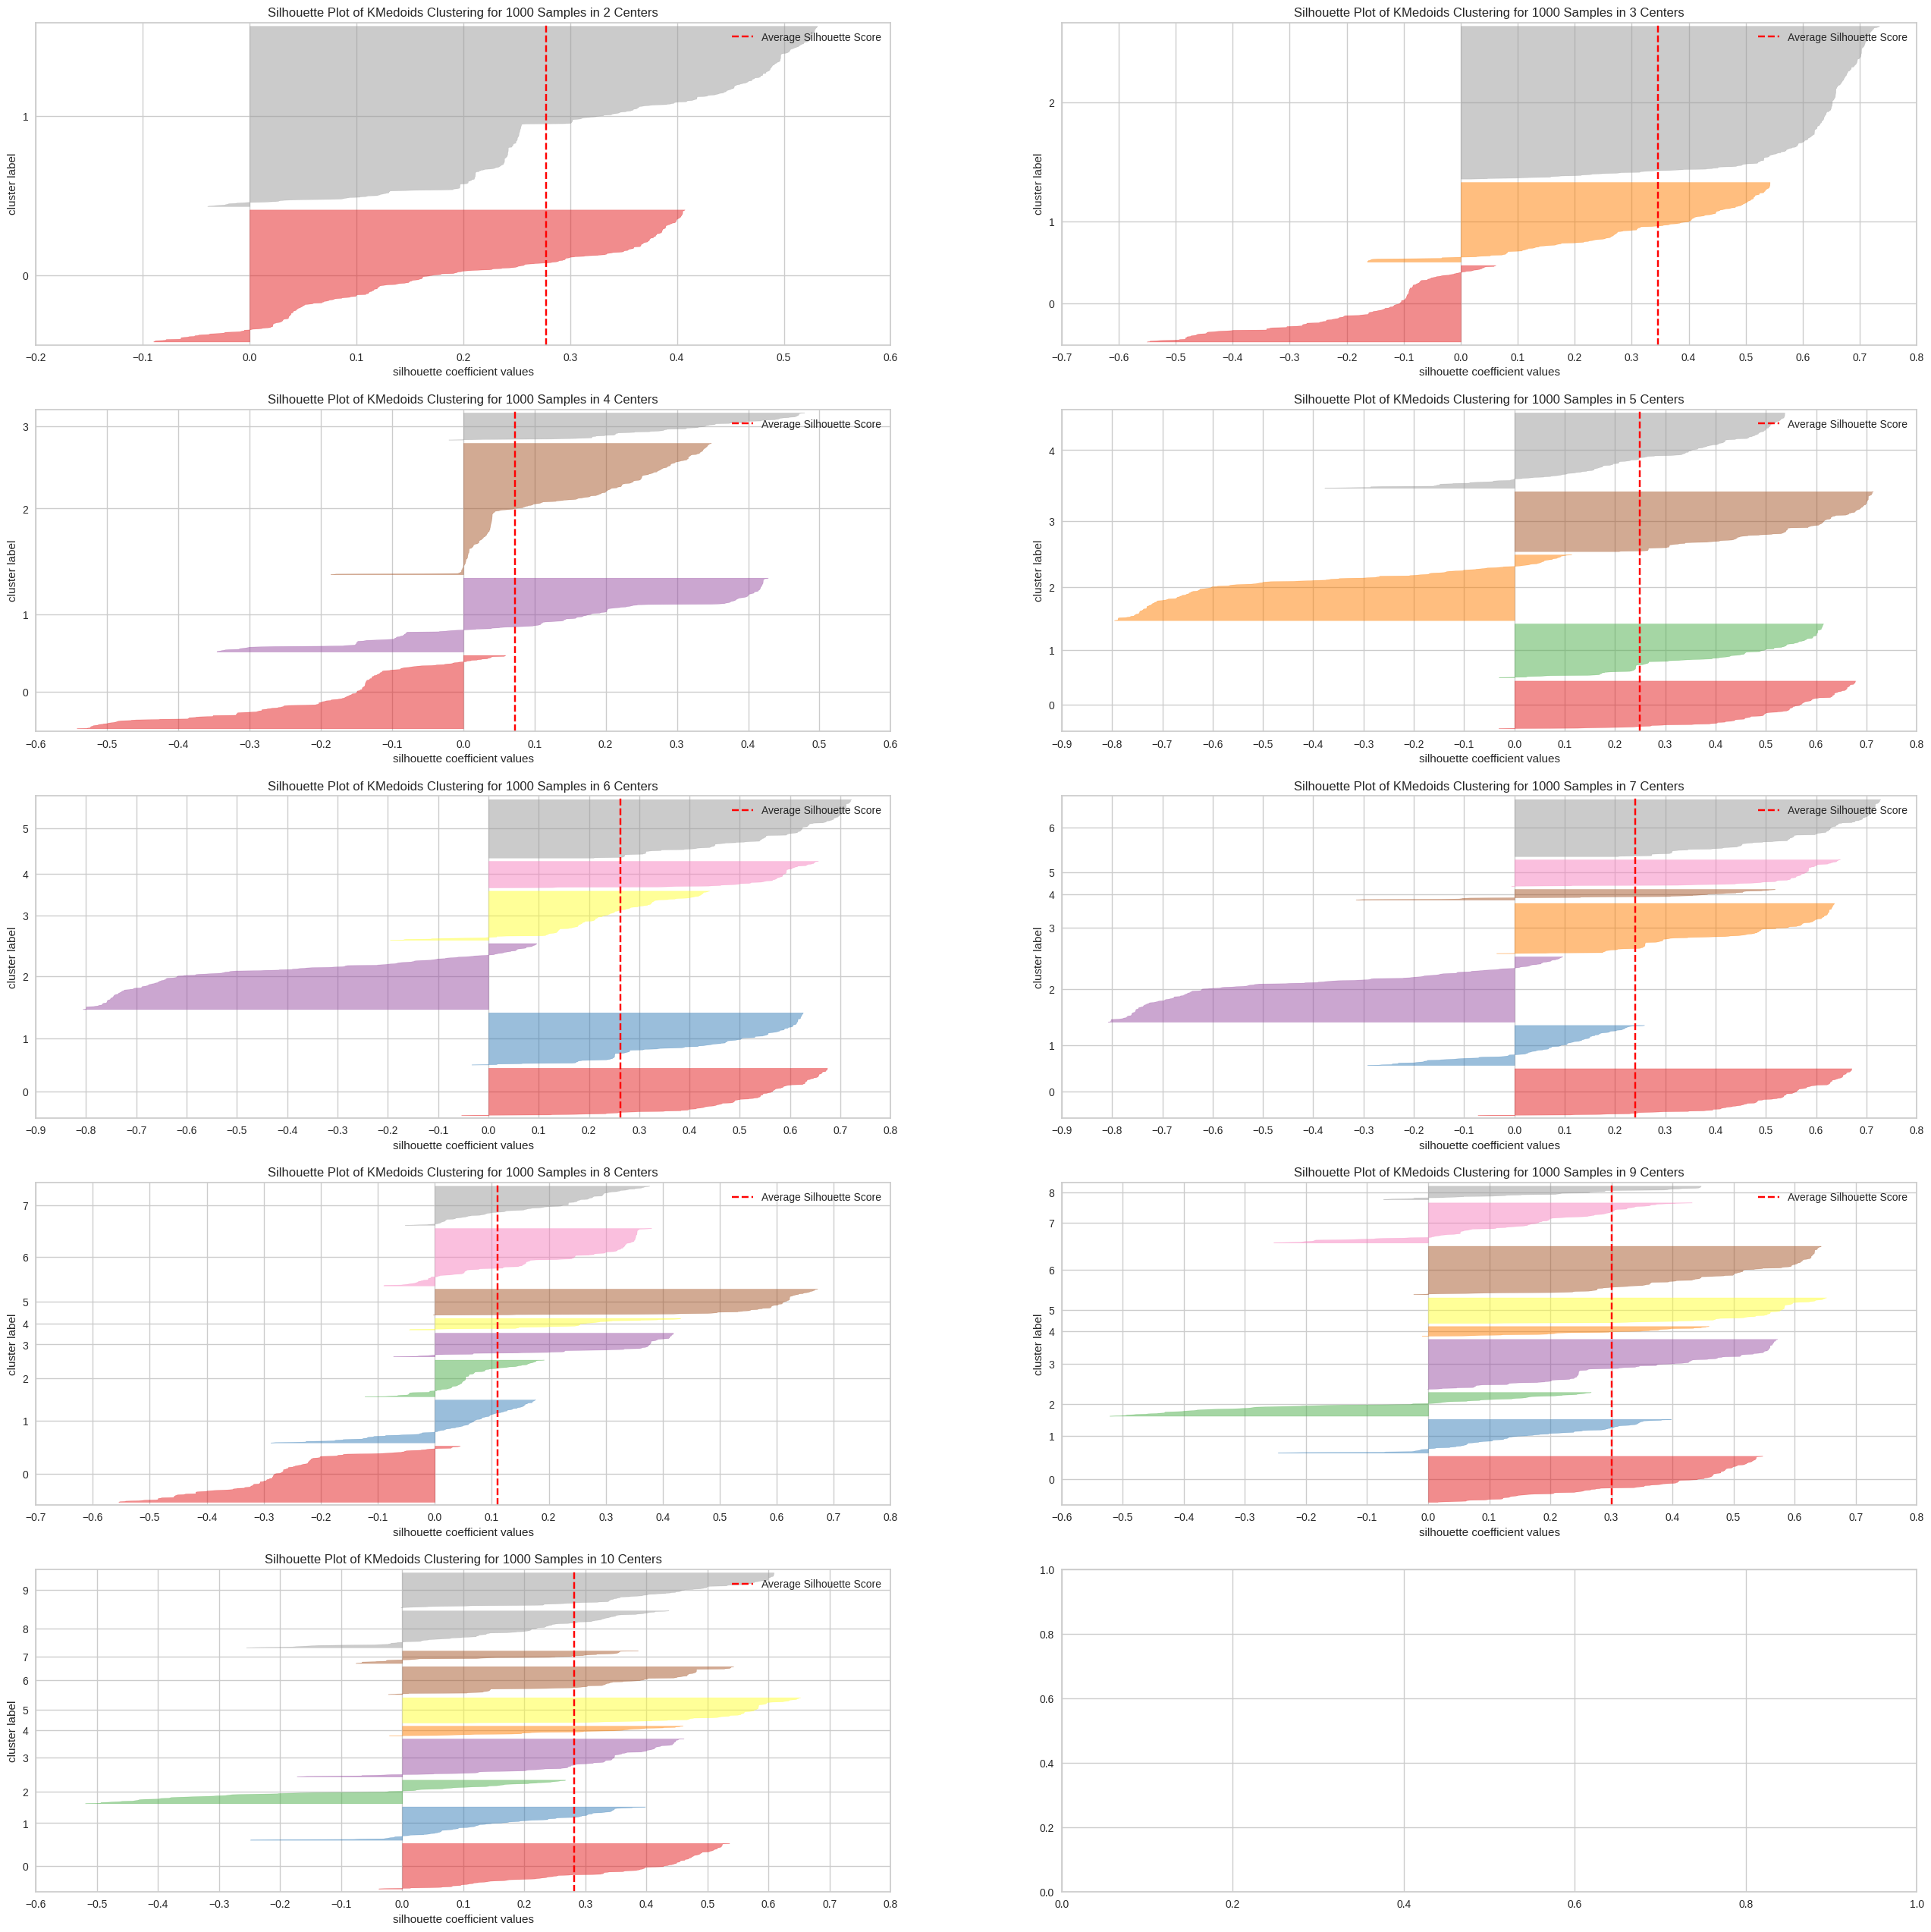

In [54]:
#Bagian eksekusi inspeksi kluster
inspnormal = inspeksi_klus(nilkomp) #Kondisi normal

1. Nilai Inspeksi menunjukan kenaikan dari 2 ke 3 sebelum nilai mengalami fluktuasi untuk kondisi normal **[sebelum pemasangan seleksi fitur]** meyakinkan hasil untuk mendapatkan 3 kluster.
2. Nilai di kluster3 paling tinggi walau semua nilai tidak mencapai 0,55 yang merupakan nilai minimal untuk kondisi **"Normal"**

In [55]:
#Deklarasi Batas untuk fungsi utama di normal
silmin = minsil #nilai siluet minimal
optmin = optsil # nilai siluet optimal
maxex = 43200 #12 jam dalam detik
#ke kumpulan fungsi

In [56]:
# Fungsi pemotongan df menjadi berbagai macam ukuran
def data_chunks(data, chunk_size):
    for i in range(0, len(data), chunk_size):
        yield data[i:i + chunk_size]

# Bagian divisiv kluster dengan K-modoid
def dynamic_divisive_clustering(data_chunk, max_tolerance):
    kmeans_model = KMeans(n_clusters=2, n_init=10, random_state=42)
    labels = kmeans_model.fit_predict(data_chunk)

    # Calculate average silhouette score for this chunk
    avg_silhouette = silhouette_score(data_chunk, labels)

    # Check if the score meets the tolerance level
    if avg_silhouette < max_tolerance:
        print(f"Nilai siluet dengan angka {avg_silhouette:.4f} di atas toleransi maksimum.")

    rounded_silhouette = round(avg_silhouette, 4)
    print(f"Nilai rata-rata siluet per bagian data: {rounded_silhouette}")

    return rounded_silhouette

# Fungsi pengaturan potongan data
def process_data_in_chunks(data, max_tolerance):
    chunk_size = len(data) // cpu_count() + 1  # Inspeksi analisis potongan data
    results = []

    start_time = time.time()

    for chunk in data_chunks(data, chunk_size):
        elapsed_time = time.time() - start_time

        if elapsed_time > maxex:
            print("Penghentian karena batas waktu.")
            break

        silhouette_score = dynamic_divisive_clustering(chunk, max_tolerance)
        results.append(silhouette_score)

    return results
# Bagian evaluasi
def evaluate_overall_silhouette(data, max_tolerance):
    overall_scores = process_data_in_chunks(data, max_tolerance)

    if not overall_scores:
        print("Nilai yang dicari belum tersedia.")
        return None

    overall_score = np.round(np.mean(overall_scores),4)

    # Count how many scores meet the thresholds
    min_count = sum(score >= silmin for score in overall_scores)
    opt_count = sum(score >= optmin for score in overall_scores)

    print(f"Nilai siluet rata-rata untuk dataset total: {overall_score}")
    print(f"Nilai potongan yang optimal untuk analisis perhitungan: {min_count}")
    print(f"Nilai potongan yang minimal untuk analisis perhitungan: {opt_count}")

    if overall_score >= optmin:
        print(f"Nilai sudah optimal karena nilai mencapai : {overall_score}")
    elif (overall_score >= silmin) and (overall_score < optmin):
        print(f"Nilai masil dalam kisaran minimal : {overall_score}")
    else:
        print(f"Nilai siluet di bawah karena nilai : {overall_score}")

    return overall_score

# Function to prepare plots
def plot_elbow_method(silhouettes):
    plt.figure(figsize=(11, 6))
    plt.plot(range(1, len(silhouettes) + 1), silhouettes, marker='o')
    plt.title('Inspeksi total siluet per kluster')
    plt.xlabel('Jumlah Kluster')
    plt.ylabel('Nilai siluet')
    plt.xticks(range(1, len(silhouettes) + 1))
    plt.grid()
    plt.show()
#ke Persiapan paralel

In [57]:
# Fungsi Persiapan paralel
def run_parallel_clustering(data, max_tolerance):
    with Pool(processes=os.cpu_count()) as pool:
        # Oper nilai toleransi
        results = pool.starmap(dynamic_divisive_clustering, [(chunk, max_tolerance) for chunk in [data] * os.cpu_count()])
    return results
  #ke persiapan data

In [58]:
#Persiapan data dan toleransi maksimal
datan = nilkomp.copy()
max_tolerance = 0.225

In [59]:
#Eksekusi untuk kondisi normal
nilratnor = evaluate_overall_silhouette(datan, max_tolerance) #normal

Nilai rata-rata siluet per bagian data: 0.8408
Nilai rata-rata siluet per bagian data: 0.6244
Nilai siluet rata-rata untuk dataset total: 0.7326
Nilai potongan yang optimal untuk analisis perhitungan: 2
Nilai potongan yang minimal untuk analisis perhitungan: 1
Nilai sudah optimal karena nilai mencapai : 0.7326


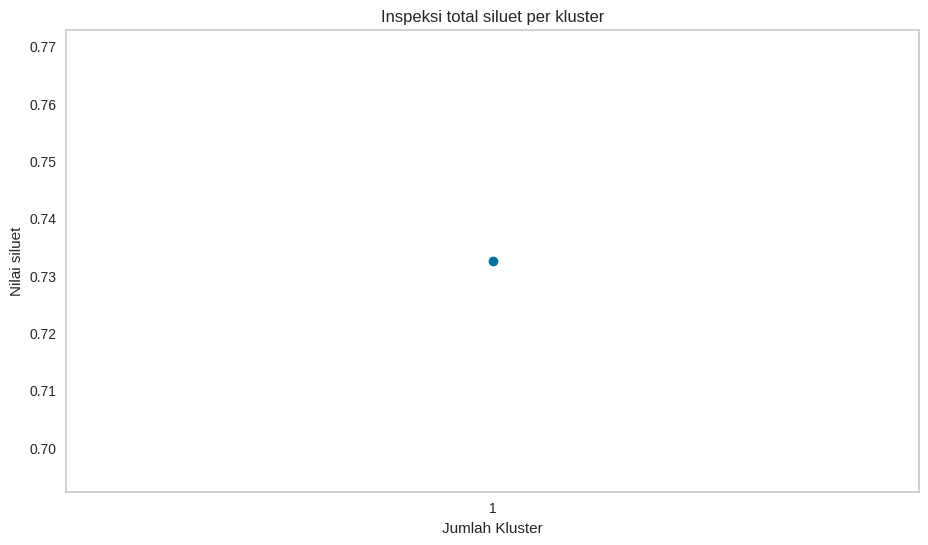

In [60]:
#cetak hasil (untuk konsol)
grfk = plot_elbow_method([nilratnor]) #normal
grfk

In [61]:
#Fungsi evaluasi nilai rata-rata kondisi normal ('overal_score')
def inspect_overall_silhouette(data, dataset_name, sample_size=1000):
  #Penyalinan Data
    data_scaled = data.copy()
    #Persiapan nilai siluet
    silhouette_scores = []
    nilaik = range(2,11)
    #cek kondisi data
    if data_scaled.shape[0] > sample_size:
        # Teknik penyampelan
        if isinstance(data_scaled, np.ndarray):
            random_indices = np.random.choice(data_scaled.shape[0], size=sample_size, replace=False)
            data_scaled = data_scaled[random_indices]
        # Jika data
        elif isinstance(data_scaled, pd.DataFrame):
            data_scaled = data_scaled.sample(n=sample_size, random_state=0)
        else:
            raise TypeError("Bantuk yang diizinkan hanya dalam NumPy array atau Pandas DataFrame.")
    #Iterasi
    for k in nilaik :
      kmedoids = KMedoids(n_clusters=k, random_state=500)
      clusters = kmedoids.fit_predict(data_scaled)
      score = silhouette_score(data_scaled, clusters) #dari penskalaan
      silhouette_scores.append(score)

        # Check Cluster Optimization
      if score >= 0.70:
            print(f'Silhouette score for k={k} is {score:.3f} (>= 0.70) - Klustering Optimal!')
      elif score >= 0.55:
            print(f'Silhouette score for k={k} is {score:.3f} (>= 0.55) - Proses Klustering yang Bagus!')
      else:
            print(f'Silhouette score for k={k} is {score:.3f} (< 0.55) - ada penyesuaian.')
       #Hapus data tidak penting
      del clusters
    # Hasil Visualisasi
    plt.figure(figsize=(10, 7))
    plt.plot(nilaik, silhouette_scores, marker='o', color='g')
    plt.title(f'Hasil Inspeksi Siluet untuk dataset - {dataset_name}')
    plt.xlabel('Total Klusters (k)')
    plt.ylabel('Nilai Siluet')
    plt.xticks(nilaik)
    plt.axhline(y=0.70, color='b', linestyle='--', label='Rekomendasi: 0.70')
    plt.axhline(y=0.55, color='r', linestyle='--', label='Minimal: 0.55')
    plt.legend()
    plt.grid()
    plt.show()

Silhouette score for k=2 is 0.417 (< 0.55) - ada penyesuaian.
Silhouette score for k=3 is 0.243 (< 0.55) - ada penyesuaian.
Silhouette score for k=4 is 0.212 (< 0.55) - ada penyesuaian.
Silhouette score for k=5 is 0.102 (< 0.55) - ada penyesuaian.


/usr/local/lib/python3.10/dist-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 5 is empty! self.labels_[self.medoid_indices_[5]] may not be labeled with its corresponding cluster (5).
  warnings.warn(


Silhouette score for k=6 is 0.068 (< 0.55) - ada penyesuaian.


/usr/local/lib/python3.10/dist-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 5 is empty! self.labels_[self.medoid_indices_[5]] may not be labeled with its corresponding cluster (5).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 5 is empty! self.labels_[self.medoid_indices_[5]] may not be labeled with its corresponding cluster (5).
  warnings.warn(


Silhouette score for k=7 is 0.061 (< 0.55) - ada penyesuaian.
Silhouette score for k=8 is 0.312 (< 0.55) - ada penyesuaian.
Silhouette score for k=9 is 0.271 (< 0.55) - ada penyesuaian.


/usr/local/lib/python3.10/dist-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 5 is empty! self.labels_[self.medoid_indices_[5]] may not be labeled with its corresponding cluster (5).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 8 is empty! self.labels_[self.medoid_indices_[8]] may not be labeled with its corresponding cluster (8).
  warnings.warn(


Silhouette score for k=10 is 0.232 (< 0.55) - ada penyesuaian.


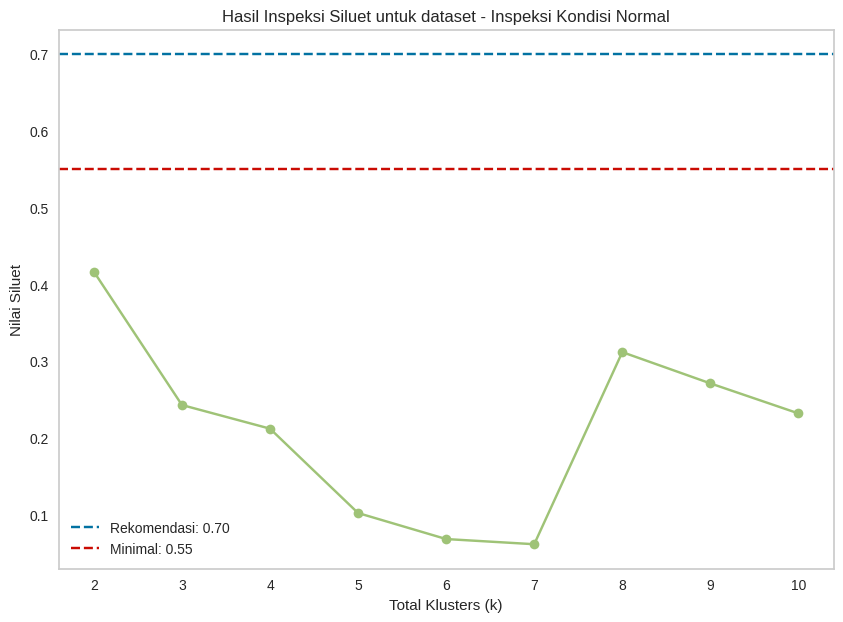

In [62]:
#EKsekusi untuk pemeriksaan
hslnormal = inspect_overall_silhouette(datan, 'Inspeksi Kondisi Normal') #normal

Keanehan nilai :
1. Jumlah kluster yang tercipta melalui grafik adalah 1 dengan nilai sudah optimal, tapi hasil akhir menghasilkan 3 kluster
2. Nilai siluet antara kluster kondisi normal dengan kluster dari **'seleksi fitur'** sangat sedikit
3. Ada 3 nilai siluet yang memenuhi minimal (2 sudah optimal)
4. Inspeksi siluet sudah menunjukan kluster 3 adalah kondisi yang baik

## **c. Feature Selection (Opsional)**

Silakan lakukan feature selection jika Anda membutuhkan optimasi model clustering. Jika Anda menerapkan proses ini, silakan lakukan pemodelan dan evaluasi kembali menggunakan kolom-kolom hasil feature selection. Terakhir, bandingkan hasil performa model sebelum dan sesudah menerapkan feature selection.

In [63]:
#Persiapan untuk Inspeksi versi seleksi fitur
def inspeksi_klus_sf(nilkomp, cluster_range=klrange, random_states=[rstateval], sample_size=size,
                  optsil=optsil, minsil=minsil, selected_features=None):

    fig, ax = plt.subplots(figsize=(32, 32), nrows=5, ncols=2)

    # Persiapan sampel jika besar
    nilai_sampel = pd.DataFrame(nilkomp)

    if sample_size < pjgdata:
        sampel = nilai_sampel.sample(n=sample_size, random_state=40)
    else:
        sampel = nilai_sampel

    # Jika fitur yang dipilih tidak None, gunakan hanya fitur tersebut
    if selected_features is not None:
        sampel = sampel[selected_features]

    # Iterasi sampel di setiap kluster dengan mengabaikan peringatan tentang klaster kosong
    for random_state in random_states:

        print(f"Dengan fasa acak: {random_state}")  # Percetakan fasa acak

        # Iterasi kluster untuk pemeriksaan dan pengabaian peringatan tentang klaster kosong
        for nklus in cluster_range:
            try:
                kmedoid_model = KMedoids(n_clusters=nklus, random_state=random_state)

                # Penyesuaian dengan kondisi sesuai
                kmedoid_model.fit(sampel.values)
                #Nilai mod
                q, mod = divmod(nklus, 2)

                sil = SilhouetteVisualizer(kmedoid_model, is_fitted=True, ax=ax[q-1][mod])

                # Peringatan kluster
                with warnings.catch_warnings():
                    warnings.filterwarnings('ignore', category=UserWarning)

                    sil.fit(sampel.values)
                 #Finalisasi
                sil.finalize()

                # Nilai siluet
                silhouette_score_value = sil.silhouette_score_

                print(f"Kluster: {nklus}, Nilai siluet: {silhouette_score_value:.3g}")

            except Exception as e:
                print(f"Error occurred for Kluster {nklus}: {e}")
  #Ke eksekusi

In [64]:
#Deklarasi seleksi fitur untuk kolom
selected_features = [5,6]

Kolom 5 dan 6 menyatakan kolom label yang ingin diperiksa

Dengan fasa acak: 600
Kluster: 2, Nilai siluet: 0.42


/usr/local/lib/python3.10/dist-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 3 is empty! self.labels_[self.medoid_indices_[3]] may not be labeled with its corresponding cluster (3).
  warnings.warn(


Kluster: 3, Nilai siluet: 0.687
Kluster: 4, Nilai siluet: 0.594


/usr/local/lib/python3.10/dist-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 3 is empty! self.labels_[self.medoid_indices_[3]] may not be labeled with its corresponding cluster (3).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 4 is empty! self.labels_[self.medoid_indices_[4]] may not be labeled with its corresponding cluster (4).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 3 

Kluster: 5, Nilai siluet: 0.439
Kluster: 6, Nilai siluet: 0.419


/usr/local/lib/python3.10/dist-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 3 is empty! self.labels_[self.medoid_indices_[3]] may not be labeled with its corresponding cluster (3).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 4 is empty! self.labels_[self.medoid_indices_[4]] may not be labeled with its corresponding cluster (4).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 5 is empty! self.labels_[self.medoid_indices_[5]] may not be labeled with its corresponding cluster (5).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 6 

Kluster: 7, Nilai siluet: 0.412
Kluster: 8, Nilai siluet: 0.391


/usr/local/lib/python3.10/dist-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 3 is empty! self.labels_[self.medoid_indices_[3]] may not be labeled with its corresponding cluster (3).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 4 is empty! self.labels_[self.medoid_indices_[4]] may not be labeled with its corresponding cluster (4).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 5 is empty! self.labels_[self.medoid_indices_[5]] may not be labeled with its corresponding cluster (5).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 6 

Kluster: 9, Nilai siluet: 0.387
Kluster: 10, Nilai siluet: 0.37


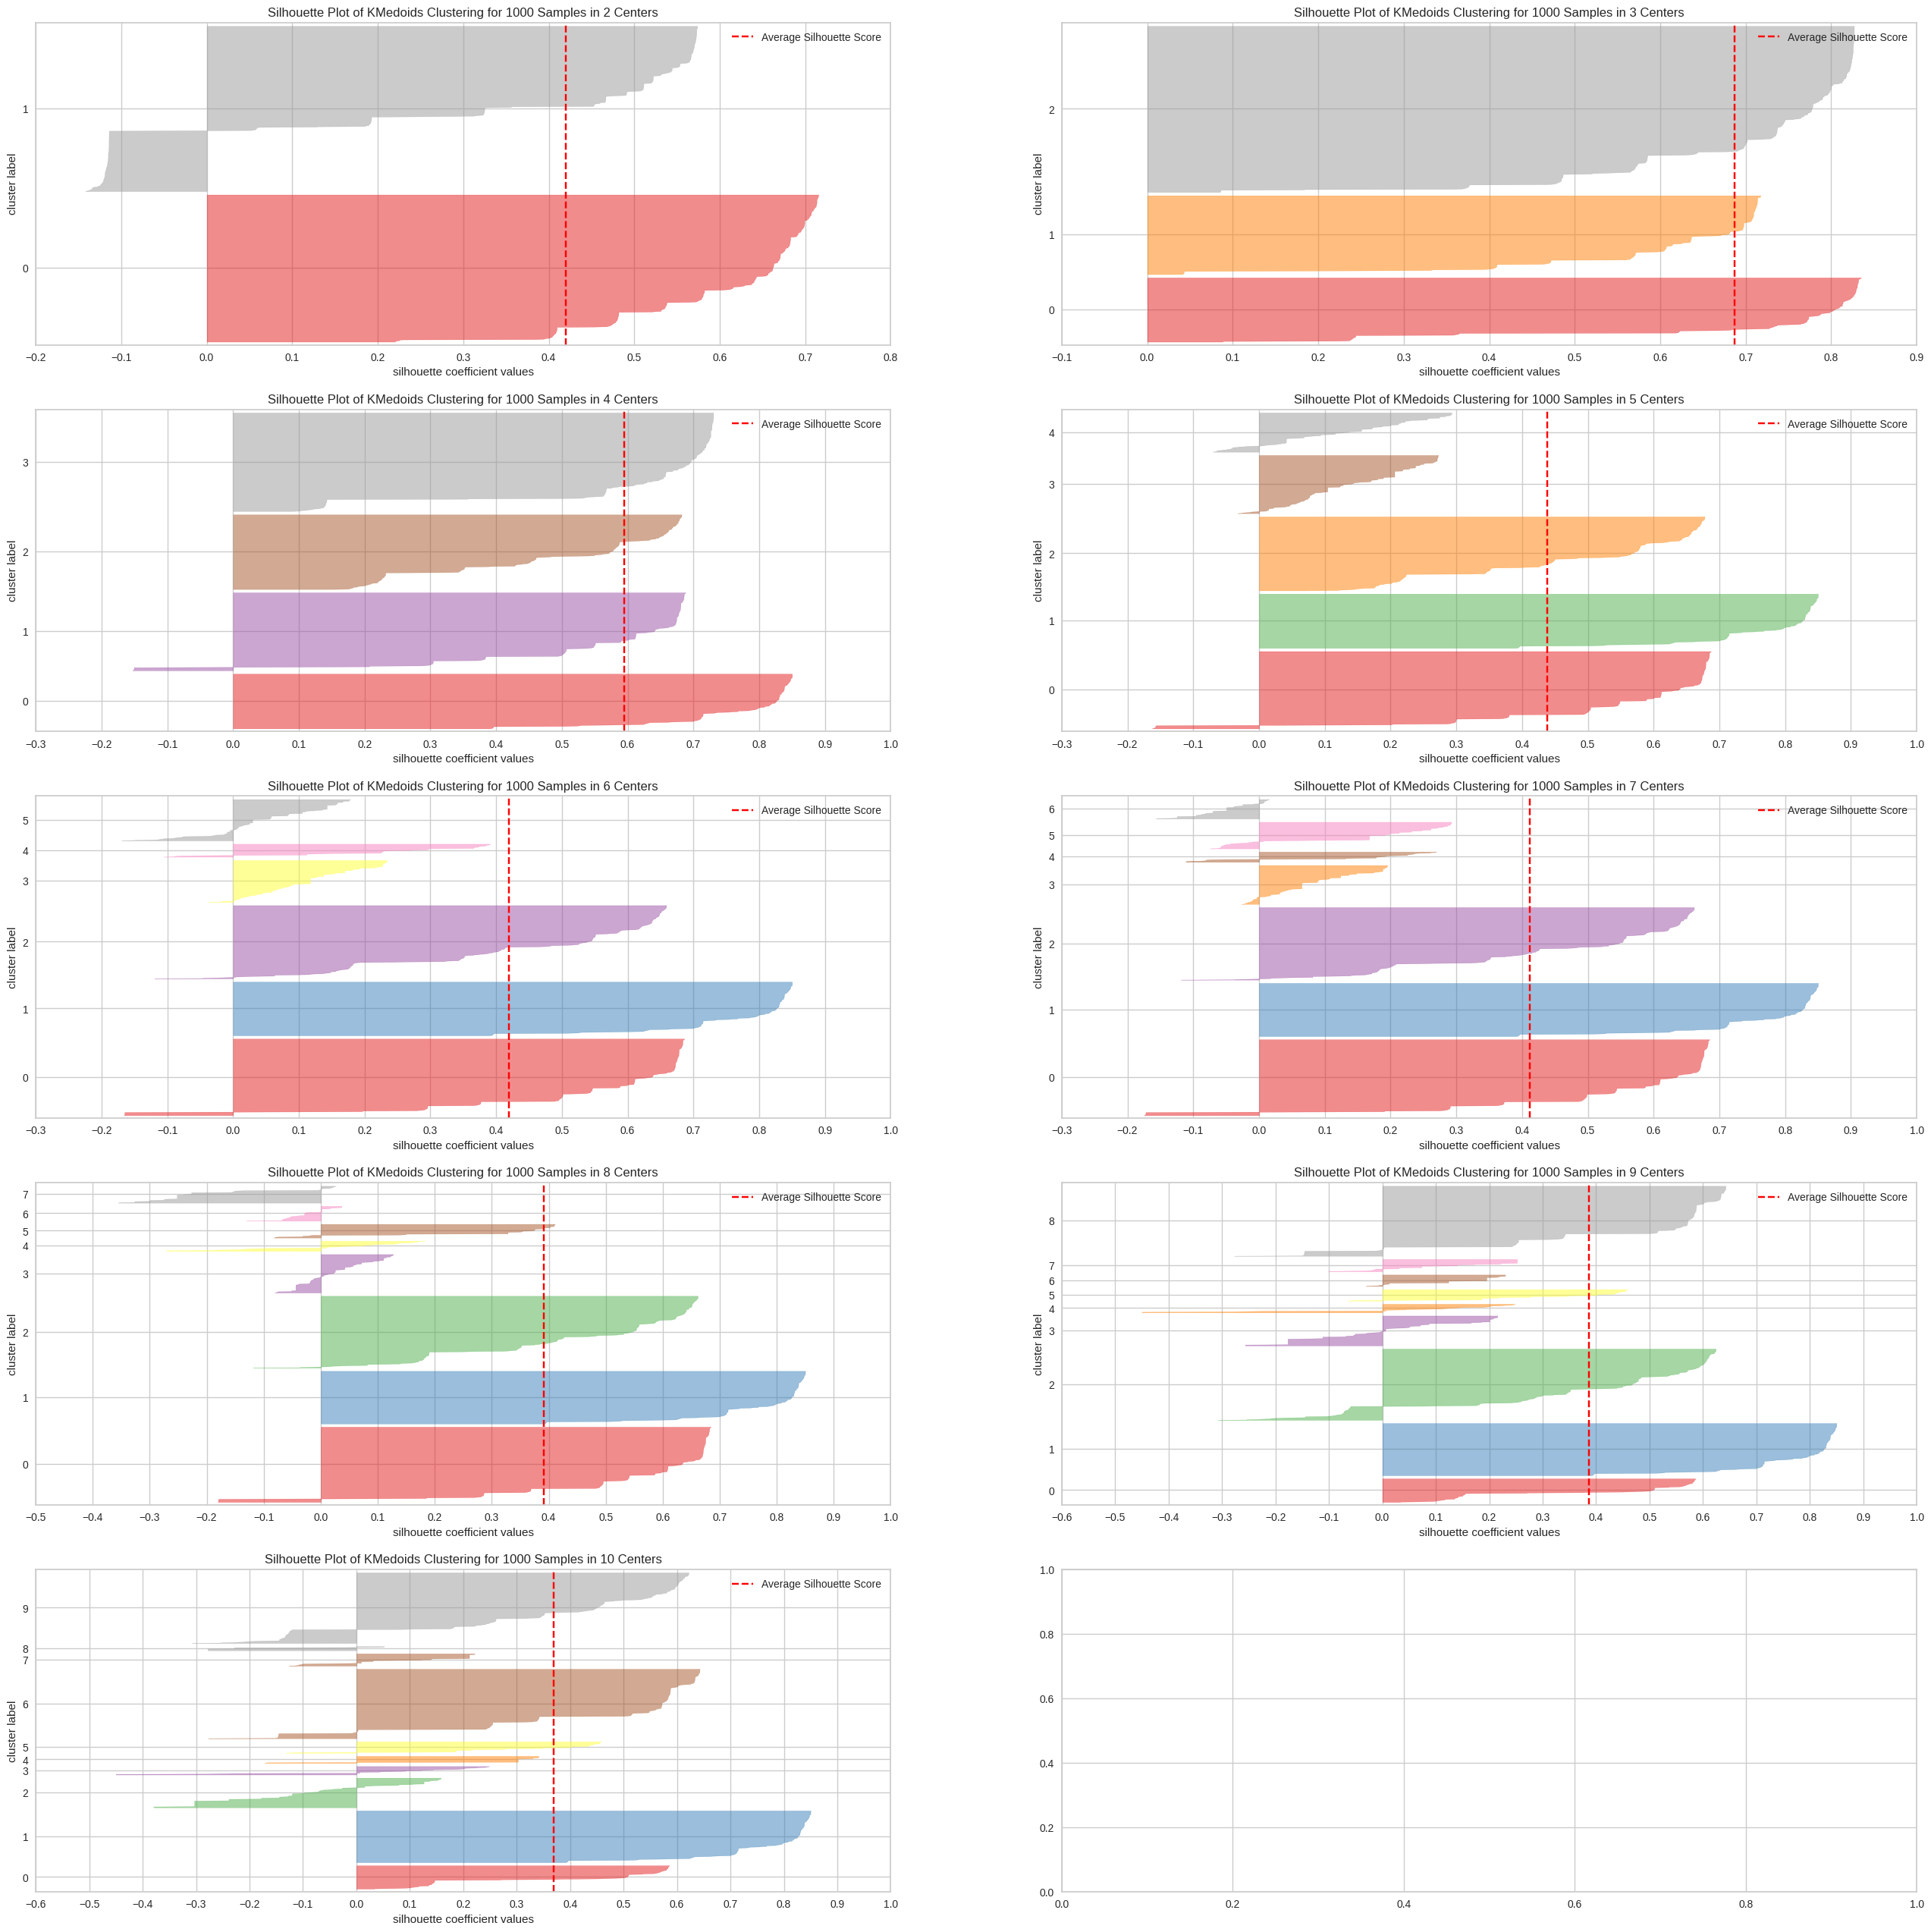

In [65]:
#Eksekusi untuk melihat fitur
inspsf = inspeksi_klus_sf(nilkomp, selected_features=selected_features)

Hasil dari 'seleksi fitur' mempertegas pemilihan 3 kluster

In [66]:
#Tahap awal fungsi dengan seleksi fitur
silminb = minsil #operan dari atas
optminb = optsil #operan dari atas
maxexb = 43200  # 12 jam dalam detik

In [67]:
# Fungsi pemotongan df menjadi berbagai macam ukuran
def data_chunks(data, chunk_size):
    for i in range(0, len(data), chunk_size):
        yield data[i:i + chunk_size]

# Fungsi untuk memilih fitur terbaik
def select_features(data, target_column, k=7):
    X = data.drop(columns=[target_column])
    y = data[target_column]
    selector = SelectKBest(score_func=f_classif, k=k)
    X_new = selector.fit_transform(X, y)
    return pd.DataFrame(X_new), selector.get_support(indices=True)

# Bagian divisiv kluster dengan K-medoids
def dynamic_divisive_clustering(data_chunk, feature_indices):
    selected_features = data_chunk.iloc[:, feature_indices]

    # Eksekusi K-means secara dinamis bedasarkan nilai siluet
    kmeans_model = KMeans(n_clusters=2, n_init=10, random_state=40)
    labels = kmeans_model.fit_predict(selected_features)

    # Perhitungan rata-rata komponen potongan
    avg_silhouette = silhouette_score(selected_features, labels)
    rounded_silhouette = round(avg_silhouette, 4)

    print(f"Nilai siluet rata-rata per potongan data: {rounded_silhouette}")

    return rounded_silhouette

# Function to process all data chunks and aggregate results
def process_data_in_chunks(data, feature_indices):
    chunk_size = len(data) // cpu_count() + 1
    results = []

    start_time = time.time()

    for chunk in data_chunks(data, chunk_size):
        elapsed_time = time.time() - start_time

        if elapsed_time > maxexb:
            print("Penghentian karena batas waktu.")
            break

        silhouette_score = dynamic_divisive_clustering(chunk, feature_indices)
        results.append(silhouette_score)

        # Dynamic adjustment based on current scores
        if silhouette_score < silminb:
            print("Silhouette score di bawah batas minimum. Menghentikan proses.")
            break

    return results

# Nilai perhitungan nilai siluet pasca penyatuan
def evaluate_overall_silhouette(data, target_column):
    selected_data, feature_indices = select_features(data, target_column)

    overall_scores = process_data_in_chunks(selected_data, feature_indices)

    if not overall_scores:
        print("Tidak ada komputasi karena nilai tidak ada.")
        return None

    overall_score = np.round(np.mean(overall_scores), 4)

    min_count = sum(score >= silminb for score in overall_scores)
    opt_count = sum(score >= optminb for score in overall_scores)

    print(f"Aspek Nilai siluet setelah penyatuan: {overall_score}")
    print(f"Nilai potongan yang optimal untuk analisis perhitungan: {min_count}")
    print(f"Nilai potongan yang minimal untuk analisis perhitungan: {opt_count}")

    if overall_score >= optminb:
        print(f"Nilai sudah optimal karena nilai mencapai : {overall_score}")
    elif (overall_score >= silminb) and (overall_score < optminb):
        print(f"Nilai masih dalam kisaran minimal : {overall_score}")
    else:
        print(f"Nilai siluet di bawah karena nilai : {overall_score}")

    return overall_score

# Evaluasi Grafik
def plot_elbow_method(silhouettes):
    plt.figure(figsize=(11, 6))
    plt.plot(range(1, len(silhouettes) + 1), silhouettes, marker='o')
    plt.title('Inspeksi total siluet per kluster')
    plt.xlabel('Jumlah Kluster')
    plt.ylabel('Nilai siluet')
    plt.xticks(range(1, len(silhouettes) + 1))
    plt.grid()
    plt.show()
 #ke tahap paralelisasi

In [68]:
#Paralelisasi untuk seleksi fitur
def run_parallel_clustering(data):
    with Pool(processes=cpu_count()) as pool:
        results = pool.map(dynamic_divisive_clustering, [data] * cpu_count())
    return results
#ke persiapan data

In [69]:
#eksekusi data melalui seleksi fitur
datan = nilkomp.copy()
dfdatan = pd.DataFrame(datan)
#cek hasil
dfdatan.info()
#ke eksekusi

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64016 entries, 0 to 64015
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       64016 non-null  float64
 1   1       64016 non-null  float64
 2   2       64016 non-null  float64
 3   3       64016 non-null  float64
 4   4       64016 non-null  float64
 5   5       64016 non-null  float64
 6   6       64016 non-null  float64
 7   7       64016 non-null  float64
dtypes: float64(8)
memory usage: 3.9 MB


Aspek pengingat saat eksekusi dengan seleksi fitur
* a. Nilai '5' adalah kemungkinan generasi
* b. Nilai '6' adalah kemungkinan jenis permainan
* c. kolom '7' adalah berat

### Eksekusi dengan Seleksi fitur

In [70]:
# Eksekusi untuk kondisi dengan seleksi fitur (di generasi konsol)
hslsfk = evaluate_overall_silhouette(dfdatan, 5)  # Kondisi dengan seleksi fitur di konsol
print(hslsfk)

Nilai siluet rata-rata per potongan data: 0.841
Nilai siluet rata-rata per potongan data: 0.6272
Aspek Nilai siluet setelah penyatuan: 0.7341
Nilai potongan yang optimal untuk analisis perhitungan: 2
Nilai potongan yang minimal untuk analisis perhitungan: 1
Nilai sudah optimal karena nilai mencapai : 0.7341
0.7341


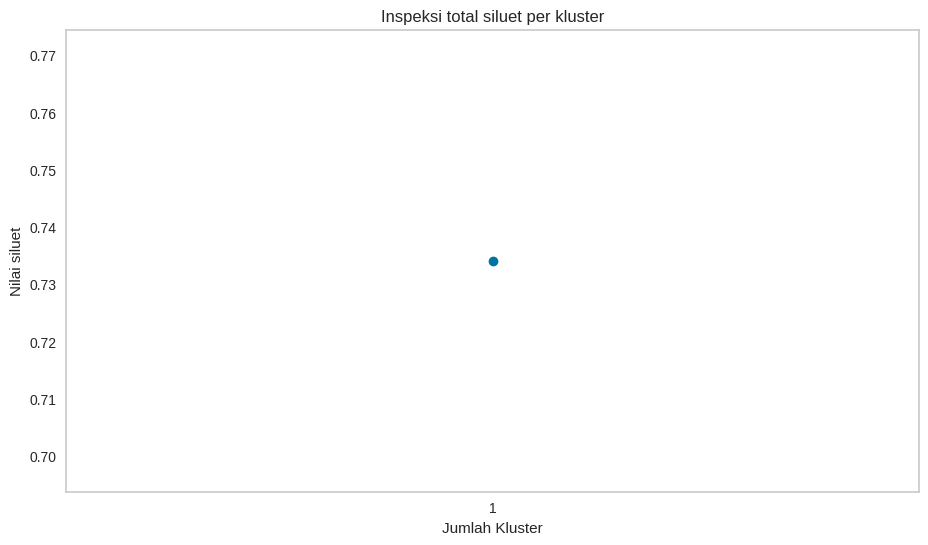

In [71]:
#grafik hasil k untuk jenis konsol
grfjk = plot_elbow_method([hslsfk])
grfjk

In [72]:
# Eksekusi untuk kondisi dengan seleksi fitur (di jenis permainan)
hslsfj = evaluate_overall_silhouette(dfdatan,6)  # Kondisi dengan seleksi fitur di jenis permainan
print(hslsfj)

Nilai siluet rata-rata per potongan data: 0.886
Nilai siluet rata-rata per potongan data: 0.5782
Aspek Nilai siluet setelah penyatuan: 0.7321
Nilai potongan yang optimal untuk analisis perhitungan: 2
Nilai potongan yang minimal untuk analisis perhitungan: 1
Nilai sudah optimal karena nilai mencapai : 0.7321
0.7321


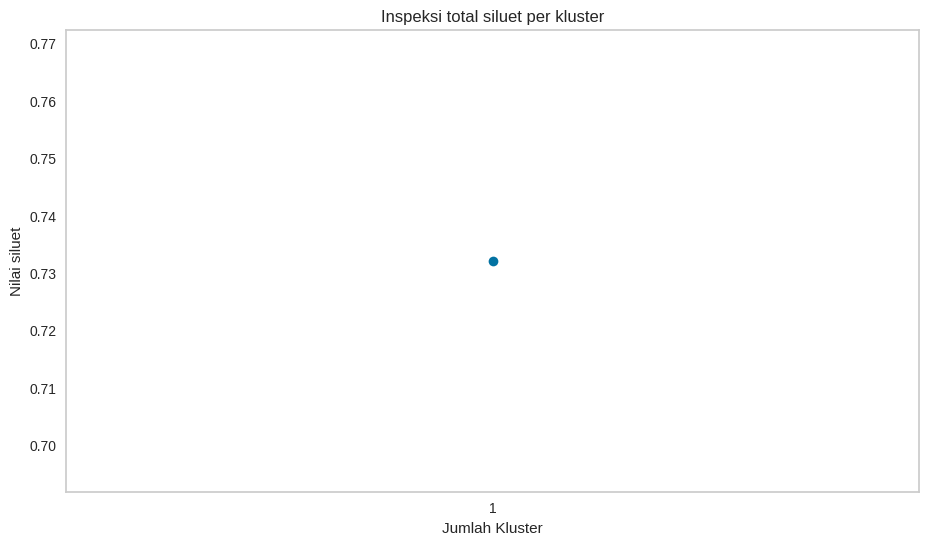

In [73]:
#grafik hasil k untuk sf jenis permainan
grfjp = plot_elbow_method([hslsfj])
grfjp

In [74]:
#rata-rata untuk dua kluster melalui rata-rata terstandardisadi (karena pengukuran sf hanya satu indikator)
berat = dfdatan.iloc[:,7].copy()
totber = np.sum(berat) #total berat
brnorm = berat/totber #normalisasi berat
#lihat kolom
dfdatan['normalisasi'] = brnorm
dfdatan.head(7)

,0,1,2,3,4,5,6,7,normalisasi
0,1016.0,637.0,99.0,52.857266,48.488431,1.105263,54.0,0.0,0.000000
1,969.5,606.0,60.0,52.105995,46.934315,1.263158,55.0,0.0,0.000000
2,807.5,841.0,47.0,29.460547,27.663272,1.210526,53.0,0.0,0.000000
3,793.0,906.0,6.0,28.601952,22.068453,1.210526,73.0,0.0,0.000000
4,754.5,618.0,41.0,32.465630,37.920440,0.421053,55.0,15.0,0.000025
5,741.0,907.0,13.0,23.021083,20.669748,0.736842,73.0,15.0,0.000025
6,737.0,976.0,11.0,20.016000,17.716927,0.789474,73.0,15.0,0.000025


In [75]:
#Penghitung normalisasi dari berat
totnorm = np.round(sum(dfdatan['normalisasi']),3)
print(totnorm) #inspeksi total karena total harus 1

1.0


In [76]:
#perhitungan rata-rata setelah pemberatan
silratdf = ((hslsfk * totnorm) + (hslsfj * totnorm))/2 #setelah diberatkan
print(f"nilai rata-rata setelah pemberatan adalah {silratdf}")

nilai rata-rata setelah pemberatan adalah 0.7331


Pertimbagan untuk seleksi fitur :
* Nilai ini adalah akumulasi dari nilai optimal dan minimal analisis penggalan data
* Aspek perhitungan berasal dari rata-rata nilai yang memenuhi kriteria "optimal" dan "minimal"
* Nilai dengan seleksi fitur mengalmi sedikit peningkatan daripada nilai di kondisi normal
* Perhitungan nilai rata-rata bertujuan untuk menginspeksi **"rata-rata setelah pemberatan"**
* Proses penerapan seleksi fitur berlangsung dua kali
 - Inspeksi di jenis permainan
 - inspeksi di jenis konsol

In [77]:
# Penyalinan Data
def overall_silhouette_sf(data, dataset_name, sample_size=1000, selected_columns=None):
    data_scaled = data.copy()

    # Jika kolom yang dipilih tidak None, gunakan hanya kolom tersebut
    if selected_columns is not None:
        data_scaled = data_scaled[selected_columns]

    # Persiapan nilai siluet
    silhouette_scores = []
    nilaik = range(2, 11)

    # Cek kondisi data
    if data_scaled.shape[0] > sample_size:
        # Teknik penyampelan
        if isinstance(data_scaled, np.ndarray):
            random_indices = np.random.choice(data_scaled.shape[0], size=sample_size, replace=False)
            data_scaled = data_scaled[random_indices]
        elif isinstance(data_scaled, pd.DataFrame):
            data_scaled = data_scaled.sample(n=sample_size, random_state=0)
        else:
            raise TypeError("Input data must be a NumPy array or a Pandas DataFrame.")

    # Iterasi untuk menghitung silhouette score
    for k in nilaik:
        kmedoids = KMedoids(n_clusters=k, random_state=500)
        clusters = kmedoids.fit_predict(data_scaled)
        #Deklarasi awal
        score = 0
        #pelabelan
        unique_labels = len(np.unique(clusters))
        if unique_labels > 1 and unique_labels < len(data_scaled):
            score = silhouette_score(data_scaled, clusters)  # Dari penskalaan
            silhouette_scores.append(score)

            # Pemeriksan nilai siluet
            if score >= 0.70:
                print(f'Silhouette score for k={k} is {score:.3f} (>= 0.70) - Klustering Optimal!')
            elif score >= 0.55:
                print(f'Silhouette score for k={k} is {score:.3f} (>= 0.55) - Proses Klustering yang Bagus!')
            else:
                print(f'Silhouette score for k={k} is {score:.3f} (< 0.55) - ada penyesuaian.')
        else:
            print(f"Skipping silhouette score for k={k} due to insufficient unique labels.")
            silhouette_scores.append(0)

        # Hapus data tidak penting
        del clusters

    # Hasil Visualisasi
    plt.figure(figsize=(11, 8))
    plt.plot(nilaik, silhouette_scores, marker='o', color='g')
    plt.title(f'Hasil Inspeksi Siluet untuk dataset - {dataset_name}')
    plt.xlabel('Total Klusters (k)')
    plt.ylabel('Nilai Siluet')
    plt.xticks(nilaik)
    plt.axhline(y=0.70, color='b', linestyle='--', label='Rekomendasi: 0.70')
    plt.axhline(y=0.55, color='r', linestyle='--', label='Minimal: 0.55')
    plt.legend()
    plt.grid()
    plt.show()
#ke eksekusi

In [78]:
#Eksekusi
selected_columns = [dfdatan.columns[5], dfdatan.columns[6]]

Hasil ini dari pemilihan seleksi

Silhouette score for k=2 is 0.680 (>= 0.55) - Proses Klustering yang Bagus!
Silhouette score for k=3 is 0.691 (>= 0.55) - Proses Klustering yang Bagus!
Silhouette score for k=4 is 0.607 (>= 0.55) - Proses Klustering yang Bagus!
Silhouette score for k=5 is 0.569 (>= 0.55) - Proses Klustering yang Bagus!
Silhouette score for k=6 is 0.490 (< 0.55) - ada penyesuaian.
Silhouette score for k=7 is 0.455 (< 0.55) - ada penyesuaian.
Silhouette score for k=8 is 0.514 (< 0.55) - ada penyesuaian.


/usr/local/lib/python3.10/dist-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 7 is empty! self.labels_[self.medoid_indices_[7]] may not be labeled with its corresponding cluster (7).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 7 is empty! self.labels_[self.medoid_indices_[7]] may not be labeled with its corresponding cluster (7).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 8 is empty! self.labels_[self.medoid_indices_[8]] may not be labeled with its corresponding cluster (8).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 7 is empty! self.labels_[self.medoid_indices_[7]] may not be labeled with its corresponding cluster (7).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 8 

Silhouette score for k=9 is 0.408 (< 0.55) - ada penyesuaian.
Silhouette score for k=10 is 0.393 (< 0.55) - ada penyesuaian.


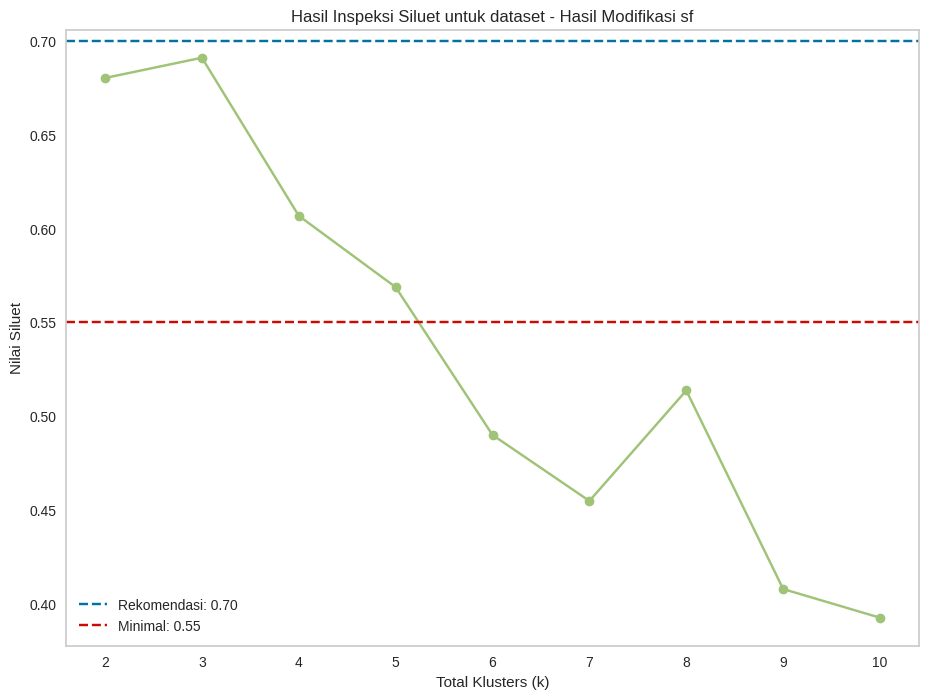

In [79]:
#Perlihatkan hasil
inspsf = overall_silhouette_sf(dfdatan, "Hasil Modifikasi sf", sample_size=1000, selected_columns=selected_columns)

### Resume inspeksi hasil normal

## **d. Visualisasi Hasil Clustering**

Setelah model clustering dilatih dan jumlah cluster optimal ditentukan, langkah selanjutnya adalah menampilkan hasil clustering melalui visualisasi.

Berikut adalah **rekomendasi** tahapannya.
1. Tampilkan hasil clustering dalam bentuk visualisasi, seperti grafik scatter plot atau 2D PCA projection.

In [80]:
#Kolom PCa
def perform_pca(data):
    #konversi ke str
    kopi = data.copy()
    kopi.columns = kopi.columns.astype(str)

    #eksekusi
    pca = PCA(n_components=2)  # Bentuk visualisasi 2D
    principal_components = pca.fit_transform(kopi)

    # Create a DataFrame for plotting
    pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

    plt.figure(figsize=(10, 6))
    plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.7)
    plt.title('Isnpeksi Hasil PCA untuk metode K-medoid')
    plt.xlabel('Konsep Prinsip 1')
    plt.ylabel('Konsep Prinsip 2')
    plt.grid()
    plt.show()

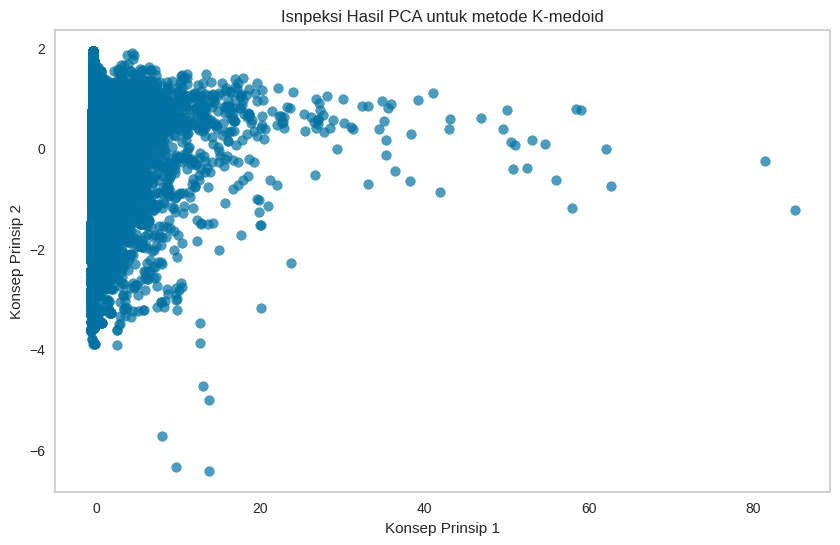

In [81]:
#Hasil pca
perform_pca(dfstdnmk)

Data terus menyebar ke bawah dan ke kanan

### Insiasi plot sebar dari data jadi

In [112]:
#Inspeksi data jadi
dfklst = pd.read_csv('/content/hslclstr.csv') #Dari bagian upload csv
dfklstc = dfklst.copy()
dfklstc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64016 entries, 0 to 64015
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   img                          64016 non-null  object 
 1   title                        64016 non-null  object 
 2   console                      64016 non-null  object 
 3   genre                        64016 non-null  object 
 4   publisher                    64016 non-null  object 
 5   total_sales                  64016 non-null  float64
 6   na_sales                     64016 non-null  float64
 7   jp_sales                     64016 non-null  float64
 8   pal_sales                    64016 non-null  float64
 9   other_sales                  64016 non-null  float64
 10  critic_score                 64016 non-null  float64
 11  release_date                 64016 non-null  object 
 12  last_update                  64016 non-null  object 
 13  kemungkinan gene

In [117]:
#Pengambilan data untuk plot sebar
newdfklstc = dfklstc.drop(columns=['kemungkinan generasi', 'kemungkinan jenis permainan']).copy()
lbljd = newdfklstc['Label'].copy() #Label
newdfklstc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64016 entries, 0 to 64015
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   img           64016 non-null  object 
 1   title         64016 non-null  object 
 2   console       64016 non-null  object 
 3   genre         64016 non-null  object 
 4   publisher     64016 non-null  object 
 5   total_sales   64016 non-null  float64
 6   na_sales      64016 non-null  float64
 7   jp_sales      64016 non-null  float64
 8   pal_sales     64016 non-null  float64
 9   other_sales   64016 non-null  float64
 10  critic_score  64016 non-null  float64
 11  release_date  64016 non-null  object 
 12  last_update   64016 non-null  object 
 13  Label         64016 non-null  object 
dtypes: float64(6), object(8)
memory usage: 6.8+ MB


In [122]:
#Kolom numerik untuk plot sebar
numdf2c = newdfklstc.iloc[:,5:11].copy()
#cek hasil sebelum penyatuan
print("Sebelum pemasangan label")
numdf2c.info() #sblm ada label
dfsct = pd.concat([lbljd, numdf2c], axis=1, sort=True, copy=True)
#setelah ada label
print("Setelah pemasangan label")
dfsct.info()

Sebelum pemasangan label
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64016 entries, 0 to 64015
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   total_sales   64016 non-null  float64
 1   na_sales      64016 non-null  float64
 2   jp_sales      64016 non-null  float64
 3   pal_sales     64016 non-null  float64
 4   other_sales   64016 non-null  float64
 5   critic_score  64016 non-null  float64
dtypes: float64(6)
memory usage: 2.9 MB
Setelah pemasangan label
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64016 entries, 0 to 64015
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Label         64016 non-null  object 
 1   total_sales   64016 non-null  float64
 2   na_sales      64016 non-null  float64
 3   jp_sales      64016 non-null  float64
 4   pal_sales     64016 non-null  float64
 5   other_sales   64016 non-null  float64
 6   c

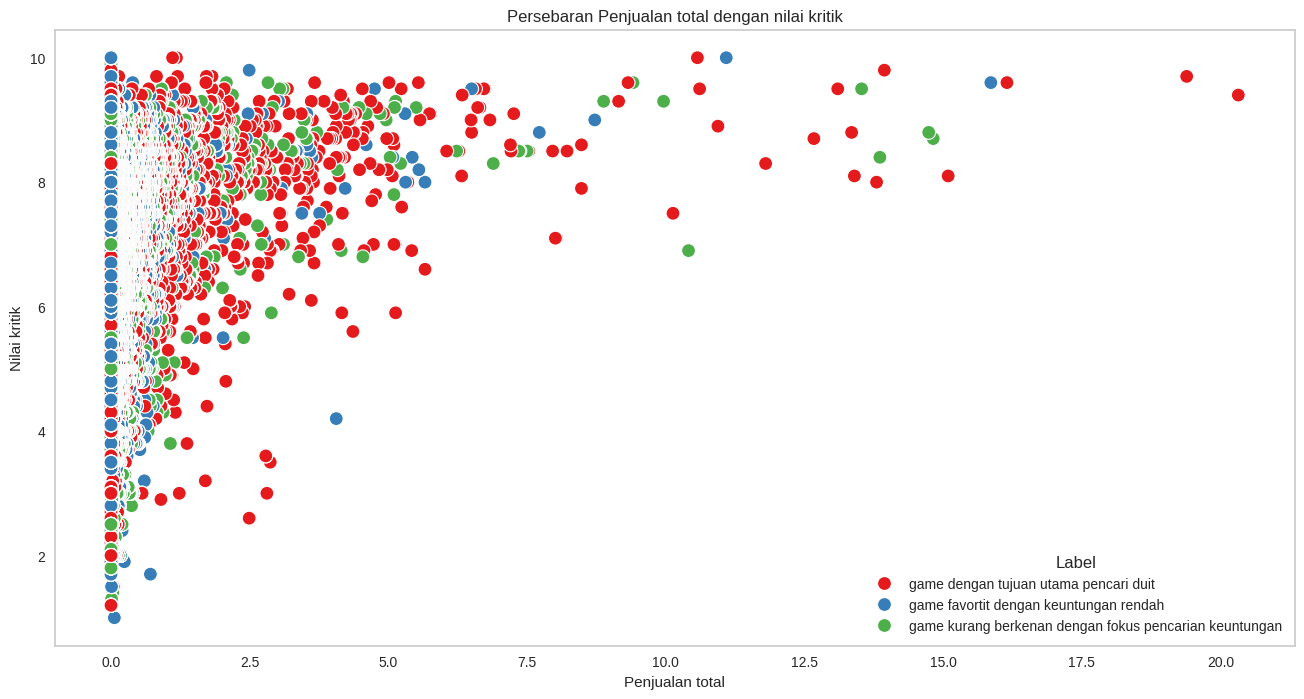

In [124]:
#Plot penyebaran untuk hasil
jnslabel = lbljd.unique().copy()
#Grafik persebaran data
plt.figure(figsize=(16, 8))
sns.scatterplot(data=dfsct, x='total_sales', y='critic_score', hue='Label', palette='Set1', s=100)
plt.title('Persebaran Penjualan total dengan nilai kritik')
plt.xlabel('Penjualan total')
plt.ylabel('Nilai kritik')
plt.legend(title='Label')
plt.grid()
plt.show()

## **e. Analisis dan Interpretasi Hasil Cluster**

Setelah melakukan clustering, langkah selanjutnya adalah menganalisis karakteristik dari masing-masing cluster berdasarkan fitur yang tersedia.

Berikut adalah **rekomendasi** tahapannya.
1. Analisis karakteristik tiap cluster berdasarkan fitur yang tersedia (misalnya, distribusi nilai dalam cluster).
2. Berikan interpretasi: Apakah hasil clustering sesuai dengan ekspektasi dan logika bisnis? Apakah ada pola tertentu yang bisa dimanfaatkan?

In [82]:
#inisiasi 'sdfc2' untuk eksekusi asli
sdfc2 = sdfkomb.copy()
sdfc2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64016 entries, 0 to 64015
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   img                          64016 non-null  object 
 1   title                        64016 non-null  object 
 2   console                      64016 non-null  object 
 3   genre                        64016 non-null  object 
 4   publisher                    64016 non-null  object 
 5   total_sales                  64016 non-null  float64
 6   na_sales                     64016 non-null  float64
 7   jp_sales                     64016 non-null  float64
 8   pal_sales                    64016 non-null  float64
 9   other_sales                  64016 non-null  float64
 10  critic_score                 64016 non-null  float64
 11  release_date                 64016 non-null  object 
 12  last_update                  64016 non-null  object 
 13  kemungkinan gene

In [83]:
#Persiapan df untuk pembuatan kluster asli
numsdfc2i = sdfc2.iloc[:, 5:11].copy() #Bagian numerikal 1
numsdfc2ii = sdfc2.iloc[:, [13,14]].copy() #Bagian 2
numsdfc2 = pd.concat([numsdfc2i, numsdfc2ii], axis=1, sort=True, copy=True)
numsdfc2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64016 entries, 0 to 64015
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   total_sales                  64016 non-null  float64
 1   na_sales                     64016 non-null  float64
 2   jp_sales                     64016 non-null  float64
 3   pal_sales                    64016 non-null  float64
 4   other_sales                  64016 non-null  float64
 5   critic_score                 64016 non-null  float64
 6   kemungkinan generasi         64016 non-null  int64  
 7   kemungkinan jenis permainan  64016 non-null  int64  
dtypes: float64(6), int64(2)
memory usage: 3.9 MB


Kolom ini untuk eksekusi asli

In [84]:
#Bagian non numerik
nonumera = sdfc2.iloc[:, :5].copy()
nonumerb = sdfc2.iloc[:, [11,12]].copy()
nonumer = pd.concat([nonumera, nonumerb], axis=1, sort=True, copy=True)
nonumer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64016 entries, 0 to 64015
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   img           64016 non-null  object
 1   title         64016 non-null  object
 2   console       64016 non-null  object
 3   genre         64016 non-null  object
 4   publisher     64016 non-null  object
 5   release_date  64016 non-null  object
 6   last_update   64016 non-null  object
dtypes: object(7)
memory usage: 3.4+ MB


In [85]:
#penyimpanan hasil
cache_dir = '/content/drive/MyDrive/colab'
os.makedirs(cache_dir, exist_ok=True)
#Persiapan aglomerasi per kluster
memory = Memory(cache_dir, verbose=1)

In [86]:
#Fungsi pengaturan jarak 'manhattan'
def manhattan_distance(a, b):
    return np.abs(a - b).sum()

In [87]:
#Inspeksi K-medoid
def k_medoids(data, k, max_iterations=100):
    # Inspeksi k-wise
    medoids_indices = np.random.choice(len(data), size=k, replace=False)
    medoids = data[medoids_indices]

    for _ in range(max_iterations):
        # Assign clusters based on the closest medoid
        distances = pairwise_distances(data, medoids, metric='cityblock')  # Using Manhattan distance
        labels = np.argmin(distances, axis=1)

        # Update medoids
        new_medoids = []
        for i in range(k):
            cluster_points = data[labels == i]
            if len(cluster_points) > 0:
                # Find the new medoid as the point with the minimum total distance to all other points in the cluster
                total_distances = np.sum(pairwise_distances(cluster_points, metric='cityblock'), axis=1)
                new_medoids.append(cluster_points[np.argmin(total_distances)])
            else:
                new_medoids.append(medoids[i])  # If no points in cluster, keep old medoid

        new_medoids = np.array(new_medoids)

        # Check for convergence (if medoids do not change)
        if np.array_equal(medoids, new_medoids):
            break

        medoids = new_medoids

    return labels
#medoid awal
rows = [1,3,6]
initial_medoids = rows

In [88]:
#Persiapan batch untuk k-medoid
ukuran = 1000  # Ukuran batch
nilsdfc2 = numsdfc2.values.copy() #salinan untuk nilai
n_batches = len(numsdfc2) // ukuran + (1 if len(numsdfc2) % ukuran != 0 else 0) #segmentasi untuk mempermudah
batches = np.array_split(nilsdfc2, n_batches)
#ke persiapan

In [89]:
#persiapan untuk fungsi dan konkatenasi (via multiprocessing)
#pemnaggilan kembali
def process_batch(batch):
   return k_medoids(batch, k=len(initial_medoids), max_iterations=100)  #iterasi untuk k-medoid
   #persiapan 'pool'
with Pool(processes=os.cpu_count()) as pool:
    label_results = pool.map(process_batch, batches)
#ke konkatenasi

In [90]:
#konkatenasi nilai label
lbltotal = np.concatenate(label_results)

In [91]:
#Visualisasi hasil total label
print(lbltotal)

[2 2 2 ... 0 0 0]


In [92]:
#Pembuatan DF baru (untuk pelabelan)
nilori = numsdfc2.values.flatten()
dfjd1 = pd.DataFrame({'Label': lbltotal})
#pemetaan label untuk nama

In [93]:
#Insersi ulang ke kolom asli
sdfc2['Label'] = dfjd1['Label']

In [94]:
#penghapusan kembali cache untuk ram
del batches, lbltotal
gc.collect() #eksekusi penghapusan

875216

In [95]:
#Pengecekan df terakhir
sdfc2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64016 entries, 0 to 64015
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   img                          64016 non-null  object 
 1   title                        64016 non-null  object 
 2   console                      64016 non-null  object 
 3   genre                        64016 non-null  object 
 4   publisher                    64016 non-null  object 
 5   total_sales                  64016 non-null  float64
 6   na_sales                     64016 non-null  float64
 7   jp_sales                     64016 non-null  float64
 8   pal_sales                    64016 non-null  float64
 9   other_sales                  64016 non-null  float64
 10  critic_score                 64016 non-null  float64
 11  release_date                 64016 non-null  object 
 12  last_update                  64016 non-null  object 
 13  kemungkinan gene

In [96]:
#Penghappusan kolom 13 dan 14
sdfc2b = sdfc2.drop(columns=['kemungkinan generasi', 'kemungkinan jenis permainan']).copy() #penanda
sdfc2b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64016 entries, 0 to 64015
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   img           64016 non-null  object 
 1   title         64016 non-null  object 
 2   console       64016 non-null  object 
 3   genre         64016 non-null  object 
 4   publisher     64016 non-null  object 
 5   total_sales   64016 non-null  float64
 6   na_sales      64016 non-null  float64
 7   jp_sales      64016 non-null  float64
 8   pal_sales     64016 non-null  float64
 9   other_sales   64016 non-null  float64
 10  critic_score  64016 non-null  float64
 11  release_date  64016 non-null  object 
 12  last_update   64016 non-null  object 
 13  Label         64016 non-null  int64  
dtypes: float64(6), int64(1), object(7)
memory usage: 6.8+ MB


Dua kolom ini (**"'kemungkinan generasi'"** & **"'kemungkinan jenis permainan'"**) tidak penting lagi untuk inspeksi

In [97]:
#penanda label
jnslbl = sdfc2b['Label'].unique().copy()
jnslbl

array([2, 0, 1])

Hasil sementara sebelum pergantian nama

In [98]:
#cek contoh kolom label
totlbl = sdfc2b['Label'].value_counts().copy()
print(totlbl)

Label
2    22504
0    21844
1    19668
Name: count, dtype: int64


* Urutan total data dari label
1 > 0 > 2

In [99]:
#inspeksi total data dari hasil label
lbltot = sdfc2b.groupby('Label').agg({
    'console':'count','genre':'count',
    'total_sales':'sum','na_sales': 'sum','jp_sales':'sum',
    'pal_sales': 'sum', 'other_sales': 'sum', 'critic_score':'mean'}).sort_values('Label').copy()
lbltot

,console,genre,total_sales,na_sales,jp_sales,pal_sales,other_sales,critic_score
Label,,,,,,,,
0,21844,21844,1531.71,888.68,584.39,471.65,150.67,7.022001
1,19668,19668,1506.88,939.08,503.22,429.66,121.14,7.020566
2,22504,22504,3567.32,1843.39,834.66,1216.28,405.43,7.093250


Aspek yang diperhatikan
1. Basis dari penamaan kluster adalah generasi dan konsol
2. Nilai kluster 0 dan 1 diatas 20 ribu
3. Total penjualan eropa di kluster 0 **"sangat sedikit"**
4. Kondisi total penjualan secara umum dan spesifik jepang di kluster **"1"** dan kluster **"2"** berbeda sangat sedikit, tetapi penjualan di luar wilayah tersebut sangat besar

In [100]:
#Penamaan ulang (tahap awal)
sdfc2['Label'] = sdfc2['Label'].replace({0:'game favortit dengan keuntungan rendah',
                                         1:'game kurang berkenan dengan fokus pencarian keuntungan',
                                         2:'game dengan tujuan utama pencari duit'}).copy()

In [101]:
#Inspeksi hasil akhir
sdfc2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64016 entries, 0 to 64015
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   img                          64016 non-null  object 
 1   title                        64016 non-null  object 
 2   console                      64016 non-null  object 
 3   genre                        64016 non-null  object 
 4   publisher                    64016 non-null  object 
 5   total_sales                  64016 non-null  float64
 6   na_sales                     64016 non-null  float64
 7   jp_sales                     64016 non-null  float64
 8   pal_sales                    64016 non-null  float64
 9   other_sales                  64016 non-null  float64
 10  critic_score                 64016 non-null  float64
 11  release_date                 64016 non-null  object 
 12  last_update                  64016 non-null  object 
 13  kemungkinan gene

Label sudah menjadi kata-kata

In [102]:
#Hapus kolom 13 dan 14
sdfc2b = sdfc2.drop(columns=['kemungkinan generasi', 'kemungkinan jenis permainan']).copy()
sdfc2b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64016 entries, 0 to 64015
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   img           64016 non-null  object 
 1   title         64016 non-null  object 
 2   console       64016 non-null  object 
 3   genre         64016 non-null  object 
 4   publisher     64016 non-null  object 
 5   total_sales   64016 non-null  float64
 6   na_sales      64016 non-null  float64
 7   jp_sales      64016 non-null  float64
 8   pal_sales     64016 non-null  float64
 9   other_sales   64016 non-null  float64
 10  critic_score  64016 non-null  float64
 11  release_date  64016 non-null  object 
 12  last_update   64016 non-null  object 
 13  Label         64016 non-null  object 
dtypes: float64(6), object(8)
memory usage: 6.8+ MB


In [103]:
#kategori label
kategori = sdfc2b['Label'].unique().copy()
kategori

array(['game dengan tujuan utama pencari duit',
       'game favortit dengan keuntungan rendah',
       'game kurang berkenan dengan fokus pencarian keuntungan'],
      dtype=object)

Nama singkat tentang 3 kluster

In [104]:
#cek kondisi setelah penamaan ulang
lbltot2 = sdfc2b.groupby(['Label']).agg({
    'title':'count','publisher' : 'nunique','total_sales':'sum','na_sales': 'sum','jp_sales':'sum',
    'pal_sales': 'sum', 'other_sales': 'sum', 'critic_score':'mean'}).sort_values('Label').copy() #pembeda dengan kondisi sebelum penamaan
#Tabel pivot ringkasa
lbltot2
#ke pembentukan grafik

,title,publisher,total_sales,na_sales,jp_sales,pal_sales,other_sales,critic_score
Label,,,,,,,,
game dengan tujuan utama pencari duit,22504,2117,3567.32,1843.39,834.66,1216.28,405.43,7.093250
game favortit dengan keuntungan rendah,21844,2034,1531.71,888.68,584.39,471.65,150.67,7.022001
game kurang berkenan dengan fokus pencarian keuntungan,19668,1943,1506.88,939.08,503.22,429.66,121.14,7.020566


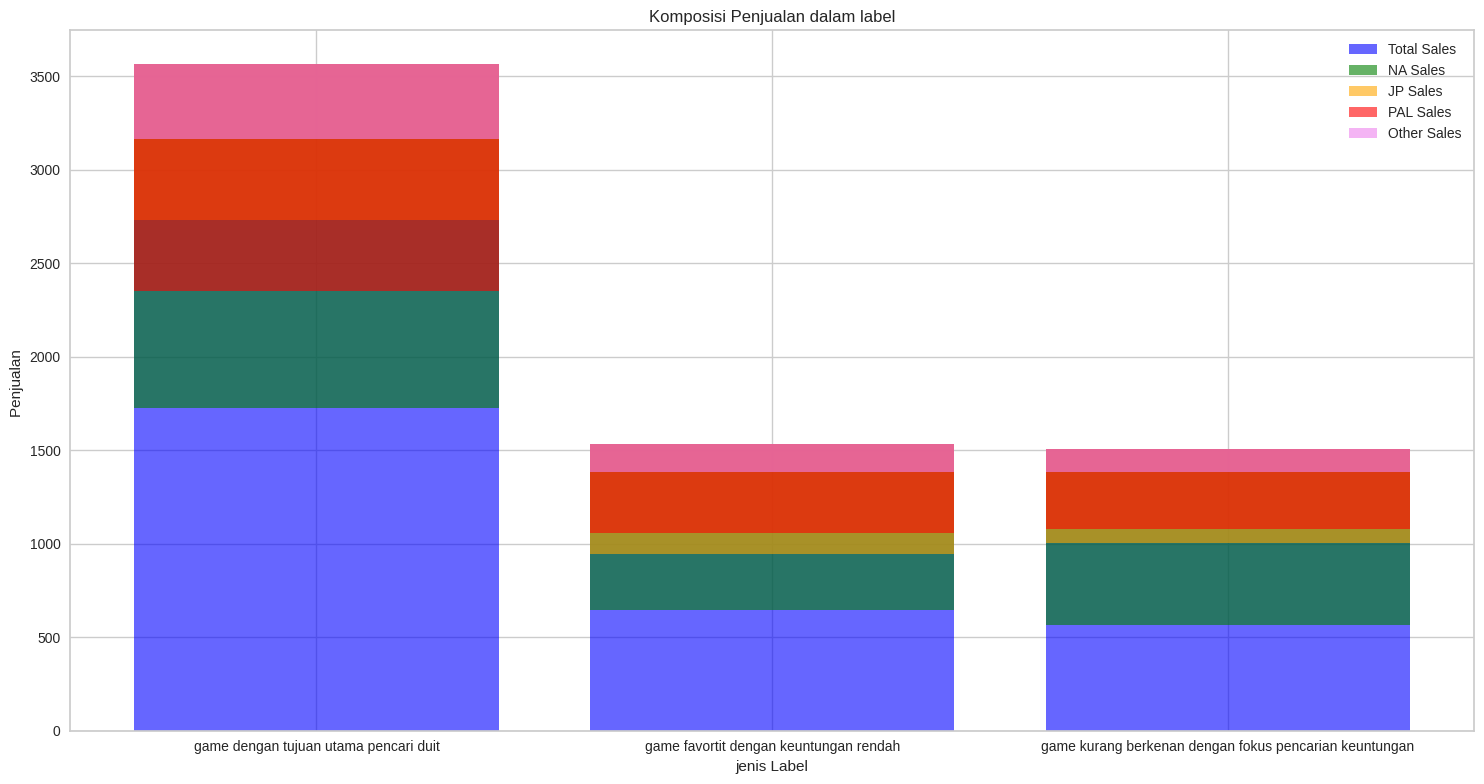

In [105]:
#Grafuk untuk pelabelan
labels = kategori.copy()
#Grafik Batang untuk penjualan di 'lbktot2'
plt.figure(figsize=(15, 8))
plt.bar(labels, lbltot2['total_sales'], color='blue', alpha=0.6, label='Total Sales') #Global
plt.bar(labels, lbltot2['na_sales'], color='green', alpha=0.6, label='NA Sales', bottom=lbltot2['total_sales'] - lbltot2['na_sales']) #Amerika Utara
plt.bar(labels, lbltot2['jp_sales'], color='orange', alpha=0.6, label='JP Sales', bottom=lbltot2['total_sales'] - lbltot2['jp_sales']) #Jepang
plt.bar(labels, lbltot2['pal_sales'], color='red', alpha=0.6, label='PAL Sales', bottom=lbltot2['total_sales'] - lbltot2['pal_sales']) # Area 'PAL'
plt.bar(labels, lbltot2['other_sales'], color='violet', alpha=0.6, label='Other Sales', bottom=lbltot2['total_sales'] - lbltot2['other_sales']) #Area lain

# Adding titles and labels
plt.title('Komposisi Penjualan dalam label')
plt.xlabel('jenis Label')
plt.ylabel('Penjualan ')
plt.xticks(rotation=0)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [106]:
#Inspeksi jenis konsol dari tabel pivot
jnsconsol = sdfc2b.groupby(['Label']).agg({'console':'nunique'}).sort_values('Label', ascending=False).copy()
print(jnsconsol)

                                                    console
Label                                                      
game kurang berkenan dengan fokus pencarian keu...       78
game favortit dengan keuntungan rendah                   72
game dengan tujuan utama pencari duit                    77


In [107]:
#Inspeksi analisis label dan pengembang melalui tabel pivot
pbinspek = sdfc2b.groupby('Label').agg({'publisher':'nunique'}).sort_values('publisher', ascending=False).copy()
print(pbinspek)

                                                    publisher
Label                                                        
game dengan tujuan utama pencari duit                    2117
game favortit dengan keuntungan rendah                   2034
game kurang berkenan dengan fokus pencarian keu...       1943


In [108]:
#Inspeksi jenis permainan dari label
jnspermainan = sdfc2b.groupby(['Label']).agg({'genre':'nunique'}).sort_values('Label', ascending=False).copy()
print(jnspermainan)

                                                    genre
Label                                                    
game kurang berkenan dengan fokus pencarian keu...     20
game favortit dengan keuntungan rendah                 20
game dengan tujuan utama pencari duit                  20


## Tulis hasil interpretasinya di sini.
###Rincian informasi tentang penamaan kluster
#### 1. Kluster '0' adalah game dengan nilai kritik yang memukau, tapi nilai penjualan tidak memberikan hasil yang bagus. Nama kluster ini adalah 'game favortit dengan keuntungan rendah'
#### 2. Nilai yang menjadi pembentuk kluster '1' adalah jumlah penjualan tinggi untuk beberapa aspek, tapi nilai kritikus rendah sehingga nama kluster ini ialah **"game kurang berkenan dengan fokus pencarian keuntungan"**
#### 3. Aspek yang diperhatikan pada kluster '2' adalah jumlah penjualan yang lebih memukau dari kluster 1 sehingga nama kluster ini adalah **'game dengan tujuan utama pencari duit'**  
#### 4. Jumlah game di kluster 2 lebih banyak dari yang lain, tapi semua label memiliki jumlah jenis permainan yang sama

### Penjelasan masing-masing kluster
#### a. Kluster '0' : **'game favortit dengan keuntungan rendah'**
    - Karekteristik : Nilai penjualan semua daerah yang merata  
    - "Nilai kritik rata-rata : 7,04"
    - "Total Pengembang berbeda" : 1840
    - Jenis konsol : 76
    - Penjualan (Total): 3060,35 juta USD [di atas 3 miliar]
- Rincian dari konsol ini adalah **"peraihan nilai kritik bagus"** bedasarkan inspeksi walau penjualan untuk semua aspek paling rendah diantara ketiganya.
- Keterangan lain yang mendukung adalah jumlah pengembang yang lebih sedikit dari kluster **'game dengan fokus pencarian keuntungan'**
- Saran untuk mengembangkan kluster ini:
  * Fokuskan ke permainan dengan nilai kritikus baik demi meningkatkan loyalitas pelanggan
  * Kalau bisa, tambahkan jenis konsol unik untuk merekrut '*pemain loyal*'

#### b. Kluster '1' : **"game kurang berkenan dengan fokus pencarian keuntungan"**
    - "Nilai kritik rata-rata : 7,07"
    - "Total pengembang berbeda" : 2296
    - Jenis konsol : 78
    - Penjualan (total) : 1551,57 juta USD [di atas 1,5 miliar]
    - Karakteristik : Variasi konsol paling banyak, penjualan eropa paling tinggi
- Fokus dari rincian konsol ini adalah kesetaraan antara nilai kritik dengan nilai penjualan.
- Nilai penjualan di kluster ini berada di antara kluster 0 dan kluster 2.
- Keunikan yang muncul saat inspeksi adalah nilai penjualan paling rendah walau variasi konsol **"sangat tinggi"** dari tiga label
- Saran untuk mengembangkan label ini
  * Tingkatkan penjualan di wilayah tertentu (paling utama amerika utara dan erpopa)
  * Cari jenis permainan yang menguntukan untuk semua wilayah, terutama amerika utara dan eropa
#### c. Kluster '2' : **"game dengan tujuan utama pencari duit"**
      - "Nilai kritik rata-rata : 7,09"
      - "Total Pengembang Unik" : 1973
      - Jenis konsol : 76
      - Penjualan (Total) : 1993,99 juta USD [di atas 1,9 miliar]
- Deskripsi dari kluster ini adalah kumpulan permainan dengan tujuan utama pencari jumlah penjualan yang tinggi di hampir semua aspek
- Hal yang paling mencolok di kluster ini adalah nilai kritikus paling tinggi.
- Saran untuk mengembangkan label ini:
  * intensifkan penjualan di eropa dengan permainan yang memiliki nilai kritik tinggi
  * Fokuskan ke penjulan di hampir semua wilayah

# **7. Mengeksport Data**

Simpan hasilnya ke dalam file CSV.

In [109]:
#ekspor hasil ke csv untuk ke klasifikasi
hsklsfnl = sdfc2.to_csv('hslclstr.csv', index=False)